# Import important library

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import cv2
import glob as gb

import tensorflow as tf
import keras

import random
import matplotlib.pyplot as plt

from skimage import exposure

import shutil
import albumentations as A

from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import csv

from sklearn.metrics import confusion_matrix

from tensorflow.keras.applications.efficientnet import preprocess_input



# Paths of the data

In [3]:
data_path = 'BoneFractureYolo8_final'
train_path = 'BoneFractureYolo8_final/train'
test_path = 'BoneFractureYolo8_final/test'
valid_path = 'BoneFractureYolo8_final/valid'
train_images_path = 'BoneFractureYolo8_final/train/images'
train_label_path = 'BoneFractureYolo8_final/train/labels'
test_images_path = 'BoneFractureYolo8_final/test/images'
test_label_path = 'BoneFractureYolo8_final/test/labels'
valid_images_path = 'BoneFractureYolo8_final/valid/images'
valid_labels_path = 'BoneFractureYolo8_final/valid/labels'
yaml_path= 'BoneFractureYolo8_final/data.yaml'

In [26]:
for folder in os.listdir(data_path):
  print(folder)

.ipynb_checkpoints
augmented
data.yaml
final_model.h5
labels_csv
model_checkpoint.h5
model_checkpoint.keras
README.dataset.txt
test
train
valid


# Number of images in each file

In [11]:
for folder in os.listdir(train_path):
    if folder == 'images':
        images = gb.glob(pathname = str(train_path + '/' + folder + '/*.jpg'))
        print(f'For training Data, Found {len(images)} in folder {folder}')

For training Data, Found 3631 in folder images


In [32]:
for folder in os.listdir(test_path):
    if folder == 'images':
        images = gb.glob(pathname = str(test_path + '/' + folder + '/*.jpg'))
        print(f'For testing Data, Found {len(images)} in folder {folder}')

For testing Data, Found 169 in folder images


In [33]:
for folder in os.listdir(valid_path):
    if folder == 'images':
        images = gb.glob(pathname = str(valid_path + '/' + folder + '/*.jpg'))
        print(f'For validating Data, Found {len(images)} in folder {folder}')

For validating Data, Found 348 in folder images


# Sizes of the images

In [12]:
# To know if the images are one size
sizes = []
for folder in os.listdir(train_path):
    images = gb.glob(pathname = str(train_path + '/' + folder + '/*.jpg'))

    for img in images:
        image = plt.imread(img)
        sizes.append(image.shape)

pd.Series(sizes).value_counts()

(512, 420, 3)    518
(512, 406, 3)    443
(406, 512, 3)    255
(512, 512, 3)    129
(420, 512, 3)    117
                ... 
(512, 447, 3)      3
(512, 290, 3)      3
(512, 178, 3)      3
(512, 382, 3)      3
(512, 423, 3)      3
Name: count, Length: 359, dtype: int64

In [34]:
sizes = []
for folder in os.listdir(test_path):
    images = gb.glob(pathname = str(test_path + '/' + folder + '/*.jpg'))

    for img in images:
        image = plt.imread(img)
        sizes.append(image.shape)

pd.Series(sizes).value_counts()

(512, 406, 3)    20
(512, 420, 3)    18
(406, 512, 3)    15
(420, 512, 3)     6
(512, 379, 3)     6
                 ..
(512, 376, 3)     1
(429, 512, 3)     1
(349, 512, 3)     1
(217, 512, 3)     1
(160, 512, 3)     1
Name: count, Length: 92, dtype: int64

In [35]:
sizes = []
for folder in os.listdir(valid_path):
    images = gb.glob(pathname = str(valid_path + '/' + folder + '/*.jpg'))

    for img in images:
        image = plt.imread(img)
        sizes.append(image.shape)

pd.Series(sizes).value_counts()

(512, 420, 3)    48
(512, 406, 3)    32
(406, 512, 3)    30
(512, 512, 3)    12
(512, 379, 3)    11
                 ..
(380, 512, 3)     1
(512, 392, 3)     1
(512, 326, 3)     1
(512, 481, 3)     1
(512, 423, 3)     1
Name: count, Length: 157, dtype: int64

# Resizing Function

In [36]:
def resize_images_in_folder(folder_path, target_size=(224, 224)):
    image_folder = os.path.join(folder_path, 'images')
    image_paths = gb.glob(os.path.join(image_folder, '*.jpg'))

    print(f"Resizing {len(image_paths)} images in {image_folder}...")

    for img_path in image_paths:
        # Read and resize image
        image = cv2.imread(img_path)
        resized = cv2.resize(image, target_size)

        # Overwrite or save
        cv2.imwrite(img_path, resized)

    print(f"Done resizing images in {folder_path}\n")

In [37]:
resize_images_in_folder(train_path)
resize_images_in_folder(test_path)
resize_images_in_folder(valid_path)

Resizing 3631 images in final_bones/BoneFractureYolo8_final/train\images...
Done resizing images in final_bones/BoneFractureYolo8_final/train

Resizing 169 images in final_bones/BoneFractureYolo8_final/test\images...
Done resizing images in final_bones/BoneFractureYolo8_final/test

Resizing 348 images in final_bones/BoneFractureYolo8_final/valid\images...
Done resizing images in final_bones/BoneFractureYolo8_final/valid



# EDA

Sample of the images

Image path: BoneFractureYolo8_final/train/images\image1_1211_png.rf.5ab3c0ac46e7934f7507f083f568cdfc.jpg
Image dimensions: 224x224
Label path: BoneFractureYolo8_final/train/labels\image1_1211_png.rf.5ab3c0ac46e7934f7507f083f568cdfc.txt
Label content: ['2 0.5908977595818815 0.35063045703125 0.4558190662020906 0.379652798828125 0.4708994843205575 0.473829736328125 0.5920408013937282 0.45563454296875 0.5908977595818815 0.35063045703125']
Raw label numbers: [2.0, 0.5908977595818815, 0.35063045703125, 0.4558190662020906, 0.379652798828125, 0.4708994843205575, 0.473829736328125, 0.5920408013937282, 0.45563454296875, 0.5908977595818815, 0.35063045703125]
224 224
Polygon points: [[132, 78], [102, 85], [105, 106], [132, 102], [132, 78]]


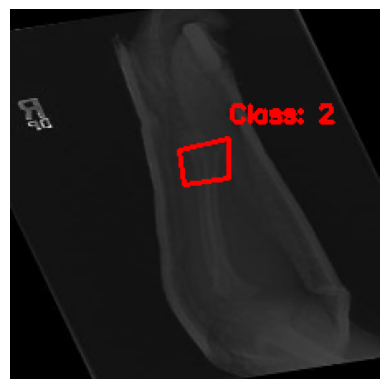

In [28]:


# Sample of the train images
image_folder = train_images_path
label_folder = train_label_path

image_name = random.choice(os.listdir(image_folder))
image_path = os.path.join(image_folder, image_name)
image = cv2.imread(image_path)  # Load as BGR

if image is None:
    print(f"Error: Could not load image {image_path}")
    exit()

print(f"Image path: {image_path}")
height, width = image.shape[:2]
print(f"Image dimensions: {width}x{height}")

# Load corresponding label
label_path = os.path.join(label_folder, image_name.replace(".jpg", ".txt"))  
print(f"Label path: {label_path}")
if os.path.exists(label_path):
    with open(label_path, 'r') as f:
        labels = f.readlines()
    print(f"Label content: {labels}")
else:
    print(f"Warning: Label file {label_path} not found")
    labels = []

for label in labels:
    numbers = list(map(float, label.strip().split()))
    print(f"Raw label numbers: {numbers}")
    if len(numbers) < 1:
        print(f"Warning: Skipping invalid label in {label_path}: {label.strip()}")
        continue
    
    class_id = numbers[0]
    coords = numbers[1:]
    
    if len(coords) % 2 != 0:
        print(f"Warning: Invalid number of coordinates in {label_path}: {label.strip()}")
        continue
    print(width, height)
    # Convert normalized coordinates to absolute
    points = []
    for i in range(0, len(coords), 2):
        x = int(coords[i] * width)
        y = int(coords[i + 1] * height)
        points.append([x, y])
    
    print(f"Polygon points: {points}")
    
    # Convert points to numpy array for drawing
    points = np.array(points, np.int32)
    points = points.reshape((-1, 1, 2))
    
    # Draw polygon
    cv2.polylines(image, [points], isClosed=True, color=(0, 0, 255), thickness=2)
    cv2.putText(image, f"Class: {int(class_id)}", (points[0][0][0], points[0][0][1] - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

# Convert BGR to RGB for matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display image
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

Image path: final_bones/BoneFractureYolo8_final/train/images/image1_431_png.rf.416ee1af4e3aecbad17020be9074e2b7.jpg
Image dimensions: 224x224
Label path: final_bones/BoneFractureYolo8_final/train/labels/image1_431_png.rf.416ee1af4e3aecbad17020be9074e2b7.txt
Label content: ['1 0.6560007160493827 0.440747158203125 0.4670045703703704 0.41548299609375 0.45474052345679017 0.49832946484375 0.637892338271605 0.53645505859375 0.6560007160493827 0.440747158203125']
Class ID: 1, Raw coordinates: [0.6560007160493827, 0.440747158203125, 0.4670045703703704, 0.41548299609375, 0.45474052345679017, 0.49832946484375, 0.637892338271605, 0.53645505859375, 0.6560007160493827, 0.440747158203125]
Box: center=(146, 98), width=104, height=93
Box corners: (94, 51), (198, 144)
Polygon points: [[146, 98], [104, 93], [101, 111], [142, 120], [146, 98]]


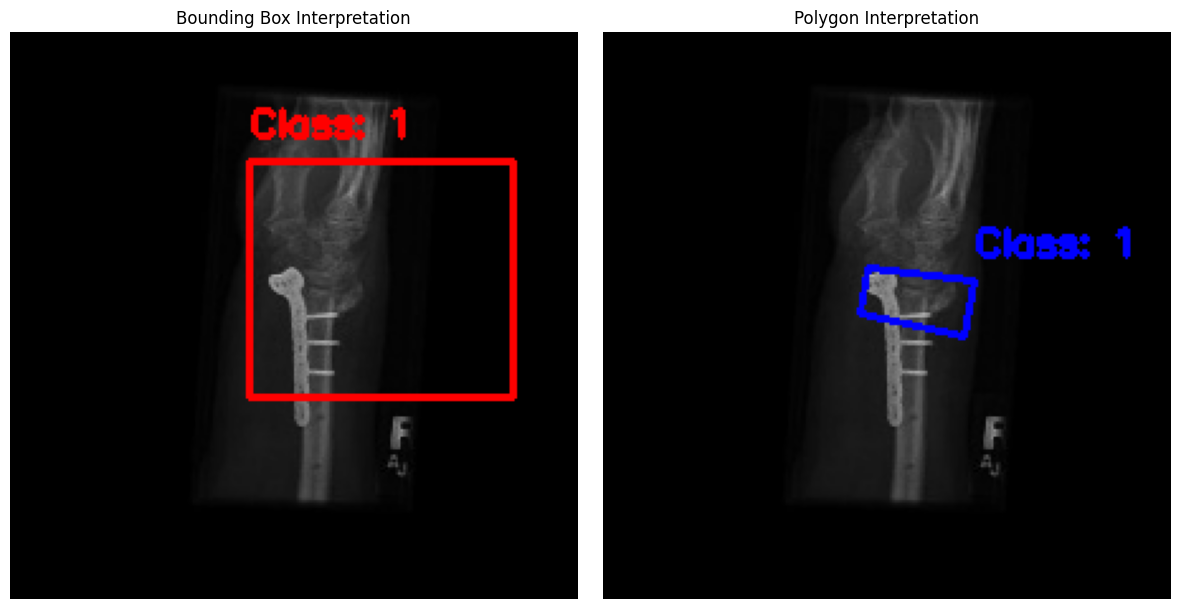

In [38]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob as gb

def visualize_yolo_annotations(image_path, label_path, is_polygon=False):
    """
    Visualize YOLO annotations on an image
    
    Parameters:
    - image_path: Path to the image file
    - label_path: Path to the corresponding YOLO label file
    - is_polygon: Whether the annotations are polygon points (True) or bounding boxes (False)
    """
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        return
    
    height, width = image.shape[:2]
    print(f"Image path: {image_path}")
    print(f"Image dimensions: {width}x{height}")
    
    # Load label
    print(f"Label path: {label_path}")
    if not os.path.exists(label_path):
        print(f"Warning: Label file {label_path} not found")
        return image
    
    with open(label_path, 'r') as f:
        labels = f.readlines()
    print(f"Label content: {labels}")
    
    # Copy image for two different visualizations
    img_box = image.copy()
    img_poly = image.copy()
    
    for label in labels:
        parts = label.strip().split()
        if len(parts) < 5:  # Need at least class_id and 4 coordinates (2 points)
            print(f"Warning: Skipping invalid label: {label.strip()}")
            continue
        
        class_id = int(float(parts[0]))
        coords = list(map(float, parts[1:]))
        print(f"Class ID: {class_id}, Raw coordinates: {coords}")
        
        # Visualization 1: Treat as bounding box (center_x, center_y, width, height)
        if len(coords) >= 4:  # Ensure we have at least 4 coordinates for a box
            # For standard YOLO format (class_id, center_x, center_y, width, height)
            center_x, center_y, box_width, box_height = coords[0], coords[1], coords[2], coords[3]
            
            # Convert normalized coordinates to absolute
            abs_center_x = int(center_x * width)
            abs_center_y = int(center_y * height)
            abs_width = int(box_width * width)
            abs_height = int(box_height * height)
            
            # Calculate top-left and bottom-right points
            x1 = int(abs_center_x - abs_width / 2)
            y1 = int(abs_center_y - abs_height / 2)
            x2 = int(abs_center_x + abs_width / 2)
            y2 = int(abs_center_y + abs_height / 2)
            
            # Draw rectangle
            cv2.rectangle(img_box, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(img_box, f"Class: {class_id}", (x1, y1-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            
            print(f"Box: center=({abs_center_x}, {abs_center_y}), width={abs_width}, height={abs_height}")
            print(f"Box corners: ({x1}, {y1}), ({x2}, {y2})")
        
        # Visualization 2: Treat as polygon points (x1, y1, x2, y2, ...)
        points = []
        for i in range(0, len(coords), 2):
            if i+1 < len(coords):  # Ensure we have both x and y
                x = int(coords[i] * width)
                y = int(coords[i+1] * height)
                points.append([x, y])
        
        if points:
            points_array = np.array(points, np.int32)
            points_array = points_array.reshape((-1, 1, 2))
            cv2.polylines(img_poly, [points_array], isClosed=True, color=(255, 0, 0), thickness=2)
            cv2.putText(img_poly, f"Class: {class_id}", (points[0][0], points[0][1]-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            print(f"Polygon points: {points}")
    
    # Convert BGR to RGB for matplotlib
    img_box_rgb = cv2.cvtColor(img_box, cv2.COLOR_BGR2RGB)
    img_poly_rgb = cv2.cvtColor(img_poly, cv2.COLOR_BGR2RGB)
    
    # Display both visualizations
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_box_rgb)
    plt.title("Bounding Box Interpretation")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_poly_rgb)
    plt.title("Polygon Interpretation")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return img_box, img_poly

def check_yolo_format(label_path):
    """
    Analyze the format of YOLO labels to determine if they're likely bounding boxes or polygons
    """
    if not os.path.exists(label_path):
        print(f"Warning: Label file {label_path} not found")
        return "unknown"
    
    with open(label_path, 'r') as f:
        labels = f.readlines()
    
    if not labels:
        return "empty"
    
    # Check the number of values in each line
    for label in labels:
        parts = label.strip().split()
        if len(parts) < 2:  # Empty or invalid
            continue
            
        values_count = len(parts) - 1  # Subtract 1 for class_id
        
        if values_count == 4:
            # Standard YOLO format: class_id, center_x, center_y, width, height
            return "bounding_box"
        elif values_count > 4 and values_count % 2 == 0:
            # Likely polygon format with x,y pairs
            return "polygon"
        else:
            # Unknown format
            return "unknown"
    
    return "unknown"

def fix_yolo_annotations(folder_path, target_size=(224, 224), annotation_type=None):
    """
    Fix YOLO annotations by determining the correct format and updating coordinates
    
    Parameters:
    - folder_path: Path to the folder containing images and labels subfolders
    - target_size: Target size for resizing images (width, height)
    - annotation_type: Force a specific annotation type ("bounding_box" or "polygon"),
                      or None to auto-detect
    """
    image_folder = os.path.join(folder_path, 'images')
    label_folder = os.path.join(folder_path, 'labels')
    
    if not os.path.exists(image_folder) or not os.path.exists(label_folder):
        print(f"Error: Image or label folder not found in {folder_path}")
        return
    
    image_paths = gb.glob(os.path.join(image_folder, '*.jpg'))
    if not image_paths:
        image_paths = gb.glob(os.path.join(image_folder, '*.png'))
    
    if not image_paths:
        print(f"Error: No images found in {image_folder}")
        return
    
    # Determine annotation type if not specified
    if annotation_type is None:
        sample_label_path = os.path.join(label_folder, 
                                        os.path.splitext(os.path.basename(image_paths[0]))[0] + '.txt')
        annotation_type = check_yolo_format(sample_label_path)
        print(f"Detected annotation type: {annotation_type}")
    
    print(f"Processing {len(image_paths)} images in {folder_path}...")
    for img_path in image_paths:
        # Get base filename without extension
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(label_folder, base_name + '.txt')
        
        # Skip if label file doesn't exist
        if not os.path.exists(label_path):
            print(f"Warning: Label file {label_path} not found for image {img_path}")
            continue
        
        # Read image and get original dimensions
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Could not read image {img_path}")
            continue
        
        orig_h, orig_w = image.shape[:2]
        print(f"Original image {img_path}: {orig_w}x{orig_h}")
        
        # Skip if already resized
        if orig_w == target_size[0] and orig_h == target_size[1]:
            print(f"Skipping {img_path}: Already resized to {target_size}")
            continue
        
        # Save original image copy for comparison
        orig_img_path = img_path.replace('.jpg', '_original.jpg').replace('.png', '_original.png')
        cv2.imwrite(orig_img_path, image)
        
        # Resize image
        resized = cv2.resize(image, target_size)
        cv2.imwrite(img_path, resized)
        print(f"Resized image {img_path} to {target_size}")
        
        # Process label file
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        # Save original label for backup
        orig_label_path = label_path.replace('.txt', '_original.txt')
        with open(orig_label_path, 'w') as f:
            f.writelines(lines)
        
        print(f"Original label content for {label_path}: {lines}")
        new_lines = []
        
        for line in lines:
            parts = line.strip().split()
            if not parts:  # Skip empty lines
                new_lines.append(line)
                continue
            
            try:
                class_id = parts[0]  # Save class_id
                values = list(map(float, parts[1:]))
                
                if annotation_type == "bounding_box" and len(values) >= 4:
                    # Standard YOLO format: center_x, center_y, width, height
                    center_x, center_y, width_norm, height_norm = values[0:4]
                    
                    # Keep normalized coordinates as they are (they're relative)
                    # Just ensure they're within [0,1]
                    center_x = min(max(center_x, 0.0), 1.0)
                    center_y = min(max(center_y, 0.0), 1.0)
                    width_norm = min(max(width_norm, 0.0), 1.0)
                    height_norm = min(max(height_norm, 0.0), 1.0)
                    
                    new_values = [center_x, center_y, width_norm, height_norm]
                    
                elif annotation_type == "polygon":
                    # For polygon points, ensure all points stay in [0,1] range
                    new_values = []
                    for val in values:
                        new_val = min(max(val, 0.0), 1.0)
                        new_values.append(new_val)
                
                else:
                    # Unknown format - keep as is but normalize to [0,1]
                    new_values = [min(max(val, 0.0), 1.0) for val in values]
                
                # Format the new line
                new_line = f"{class_id} " + ' '.join(map(str, new_values)) + '\n'
                new_lines.append(new_line)
                
            except Exception as e:
                print(f"Warning: Error processing line in {label_path}: {line.strip()} - Error: {e}")
                new_lines.append(line)  # Keep as is if there's an error
        
        # Save the updated labels
        with open(label_path, 'w') as f:
            f.writelines(new_lines)
        
        print(f"Updated label content for {label_path}: {new_lines}")
        
        # Visualize the result (before and after)
        print("Visualizing the original image with annotations:")
        visualize_yolo_annotations(orig_img_path, orig_label_path, is_polygon=(annotation_type=="polygon"))
        
        print("Visualizing the resized image with updated annotations:")
        visualize_yolo_annotations(img_path, label_path, is_polygon=(annotation_type=="polygon"))
    
    print(f"Done processing {folder_path}\n")

# Main execution
if __name__ == "__main__":
    # Example usage
    sample_image_path = 'final_bones/BoneFractureYolo8_final/train/images/image1_431_png.rf.416ee1af4e3aecbad17020be9074e2b7.jpg' # Replace with actual path
    sample_label_path = "final_bones/BoneFractureYolo8_final/train/labels/image1_431_png.rf.416ee1af4e3aecbad17020be9074e2b7.txt"  # Replace with actual path
    
   # Uncomment to analyze a single image
    visualize_yolo_annotations(sample_image_path, sample_label_path)

X-ray Intensity Statistics:


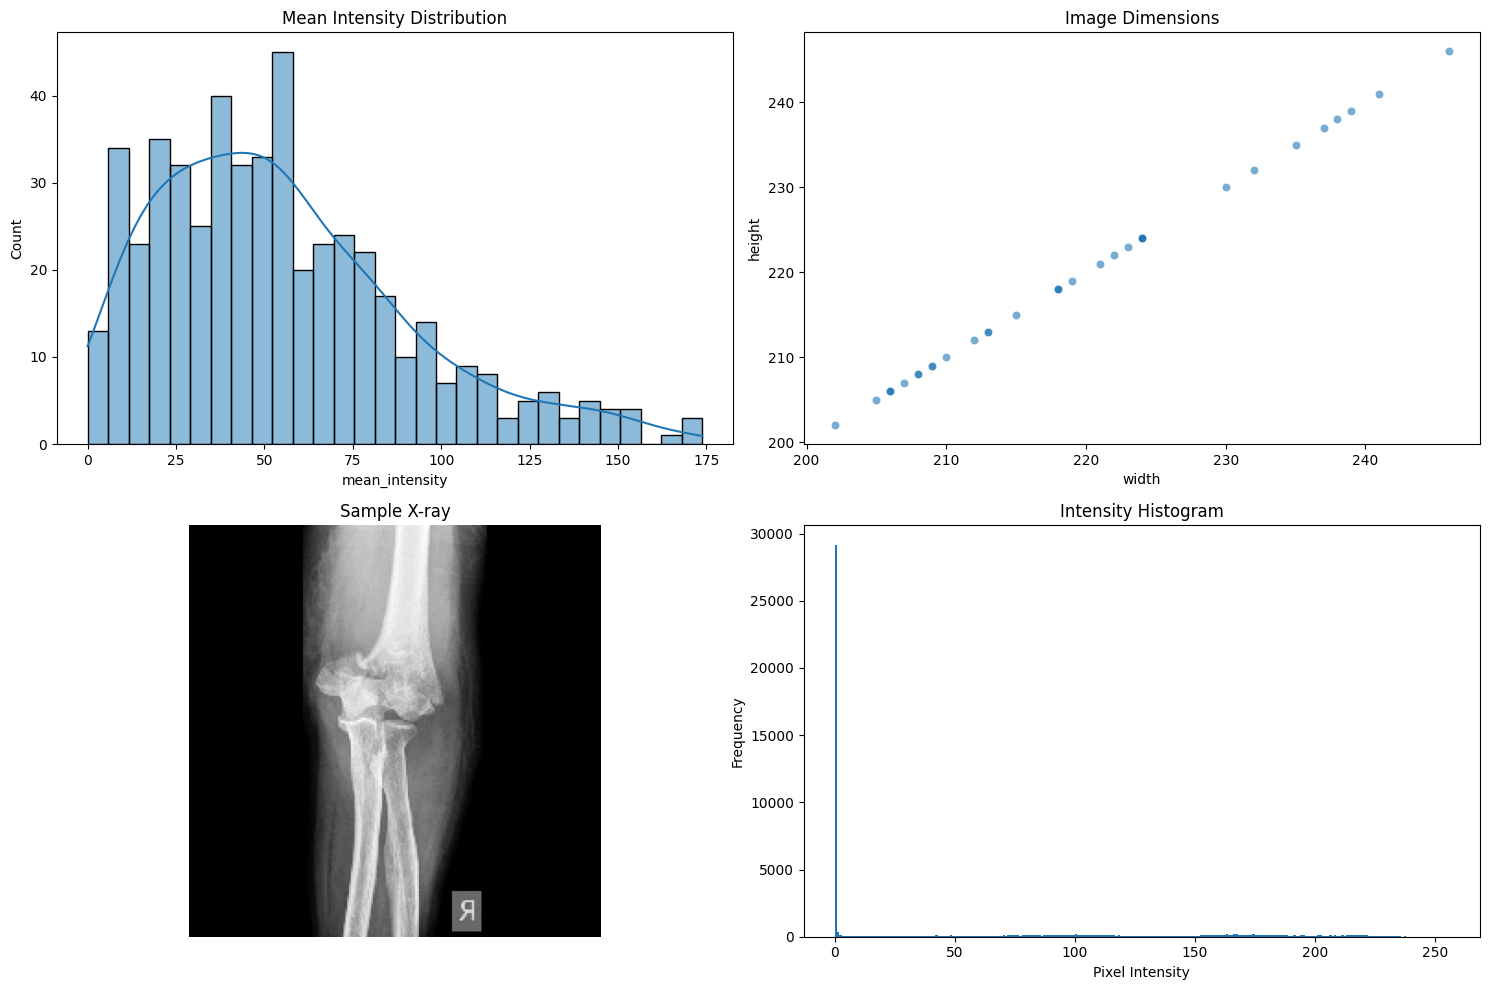

In [31]:
# Set paths (verify these!)
data_dir = "BoneFractureYolo8_final"
train_img_dir = os.path.join(data_dir, "train", "images")

# 1. X-ray Image Analysis
def analyze_xray(image_path):
    """Analyze key x-ray characteristics"""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    if img is None:
        return None

    stats = {
        "mean_intensity": np.mean(img),
        "std_intensity": np.std(img),
        "min_intensity": np.min(img),
        "max_intensity": np.max(img),
        "histogram_peak": np.argmax(np.histogram(img, bins=256)[0]),
        "width": img.shape[1],
        "height": img.shape[0]
    }
    return stats

# Process images
xray_stats = []
for img_path in sorted(gb.glob(os.path.join(train_img_dir, "*.jpg")))[:500]:
    stats = analyze_xray(img_path)
    if stats:
        xray_stats.append(stats)

df_xray = pd.DataFrame(xray_stats)
print("X-ray Intensity Statistics:")
#print(df_xray.describe())

# 2. Visualizations
plt.figure(figsize=(15, 10))

# Intensity Distribution
plt.subplot(2, 2, 1)
sns.histplot(data=df_xray, x="mean_intensity", bins=30, kde=True)
plt.title("Mean Intensity Distribution")

# Image Size Distribution
plt.subplot(2, 2, 2)
sns.scatterplot(data=df_xray, x="width", y="height", alpha=0.6)
plt.title("Image Dimensions")

# Sample Image with Histogram
plt.subplot(2, 2, 3)
# Check if the image path is valid and the image can be loaded
if os.path.exists(train_images_path) and len(os.listdir(train_images_path)) > 0:
    sample_img_path = os.path.join(train_images_path, os.listdir(train_images_path)[2])  # Use the third image
    sample_img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)
    if sample_img is not None:
        plt.imshow(sample_img, cmap='gray')
        plt.title("Sample X-ray")
        plt.axis('off')

        plt.subplot(2, 2, 4)
        plt.hist(sample_img.ravel(), bins=256, range=(0, 256))
        plt.title("Intensity Histogram")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
    else:
        print(f"Error: Could not load sample image from {sample_img_path}")
else:
    print("Error: Train images path is invalid or empty.")

plt.tight_layout()
plt.show()

# 3. Fracture vs Non-Fracture Comparison (if labels available)
if 'df_labels' in locals():
    df_merged = pd.concat([
        df_xray,
        df_labels['class_id'].rename('has_fracture')
    ], axis=1)

    plt.figure(figsize=(10, 4))
    sns.boxplot(data=df_merged, x='has_fracture', y='mean_intensity')
    plt.title("Intensity: Fracture vs Normal")
    plt.ylabel("Mean Intensity")
    plt.xlabel("Fracture Present (1=Yes)")
    plt.show()


Image: image1_4982_png.rf.de955dbcc180717b2fd57637e3a25202.jpg
Size: (224, 224) (height, width)
Intensity - Min: 0, Max: 255, Avg: 99.9


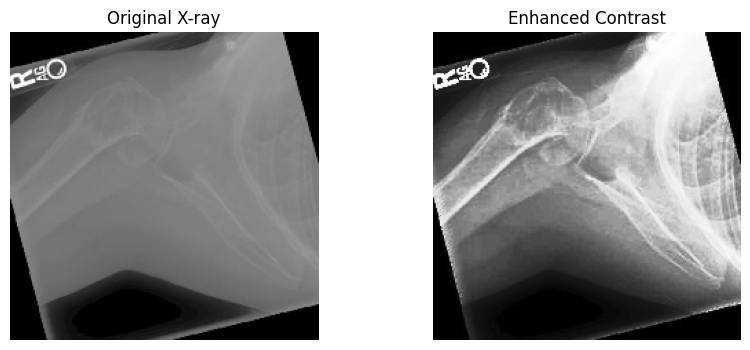


Image: image1_3519_png.rf.7f5cfa925c14b56c6d38a953b66dbe84.jpg
Size: (224, 224) (height, width)
Intensity - Min: 0, Max: 251, Avg: 21.1


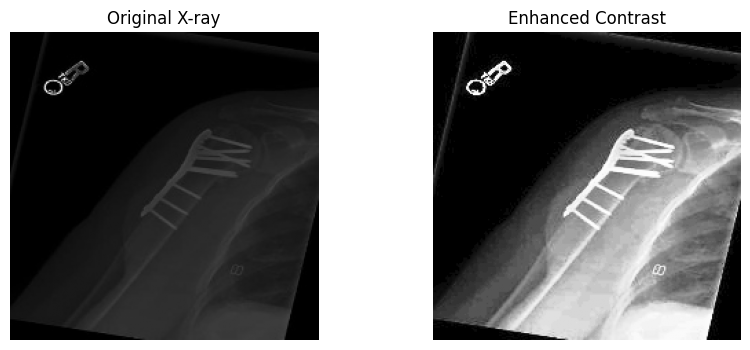


Image: image1_1447_png.rf.708f77c92737077936f2bd63a7736134_aug0.jpg
Size: (224, 224) (height, width)
Intensity - Min: 0, Max: 212, Avg: 44.1


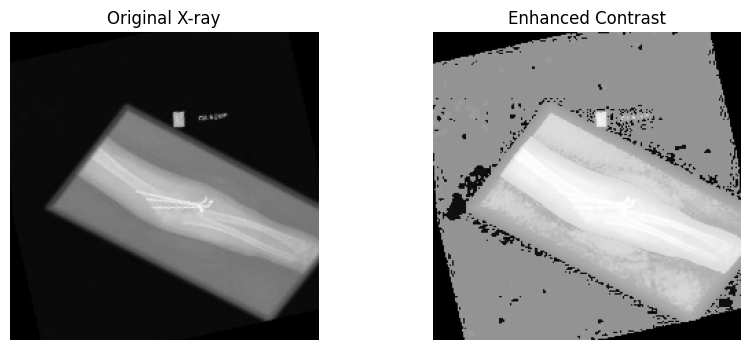


Image: image2_693_png.rf.28c48dcaa556da824f72a0b0f859ca03.jpg
Size: (224, 224) (height, width)
Intensity - Min: 0, Max: 144, Avg: 15.7


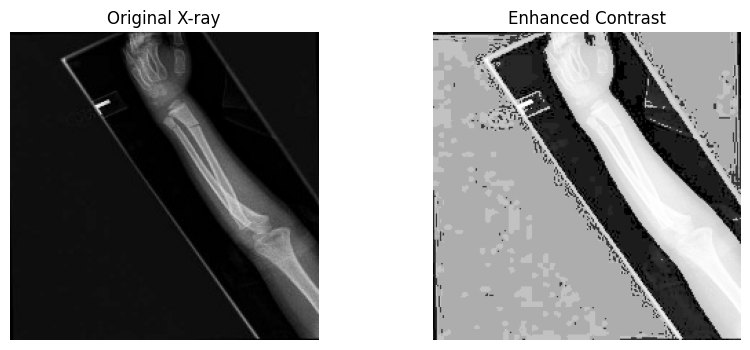


Image: image1_1087_png.rf.6fc39035a81b57c1d60891a300156355.jpg
Size: (224, 224) (height, width)
Intensity - Min: 0, Max: 125, Avg: 69.6


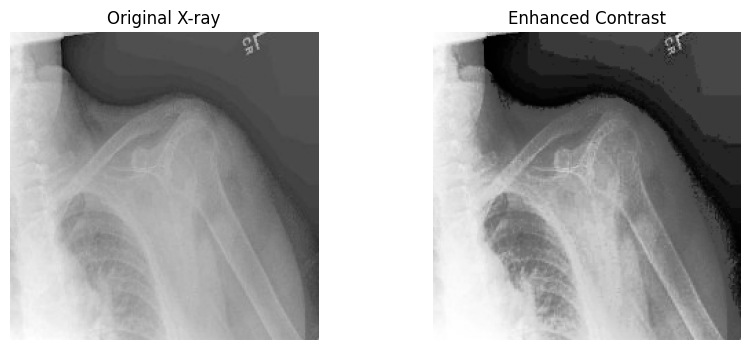


Image: image1_7603_png.rf.5766c774928ee1823cee08424fa508db_aug0.jpg
Size: (224, 224) (height, width)
Intensity - Min: 0, Max: 243, Avg: 147.6


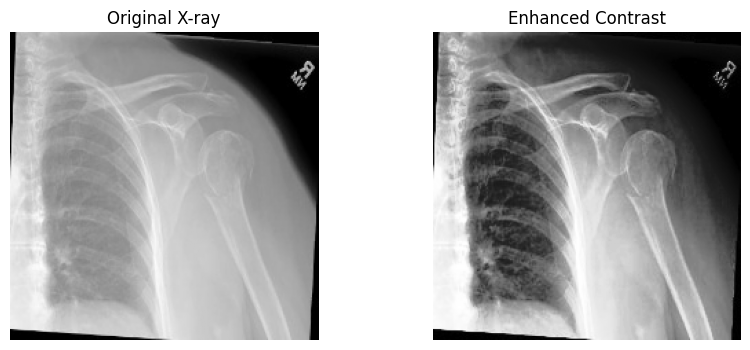


Image: image1_589_png.rf.3263943152bf4b80e684254c2326468b_aug0.jpg
Size: (224, 224) (height, width)
Intensity - Min: 0, Max: 255, Avg: 43.0


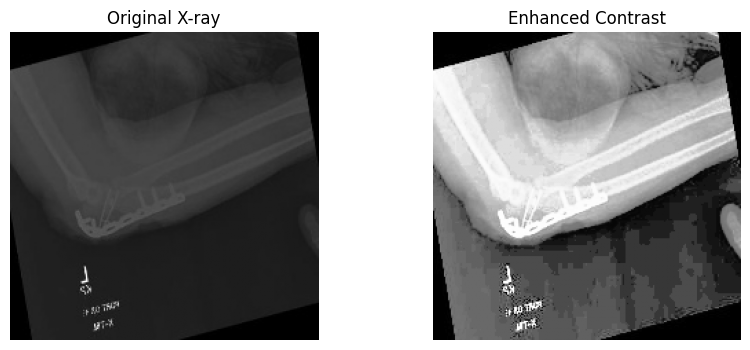


Image: image1_964_png.rf.6c2a9c8b336daa48257ead4ab986c751.jpg
Size: (224, 224) (height, width)
Intensity - Min: 0, Max: 254, Avg: 64.2


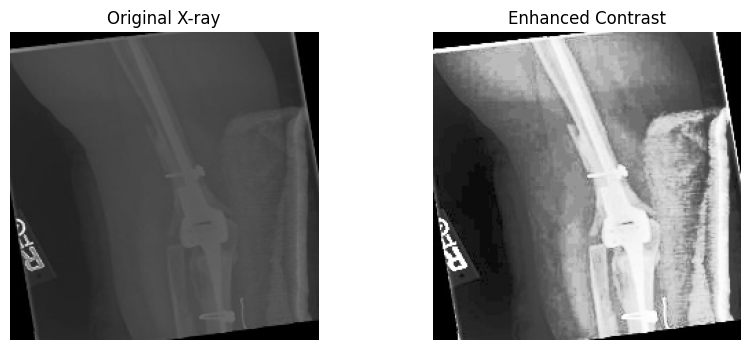


Image: image1_376_png.rf.cc7dc108ec6db52da50bd7e902713305.jpg
Size: (224, 224) (height, width)
Intensity - Min: 1, Max: 148, Avg: 18.2


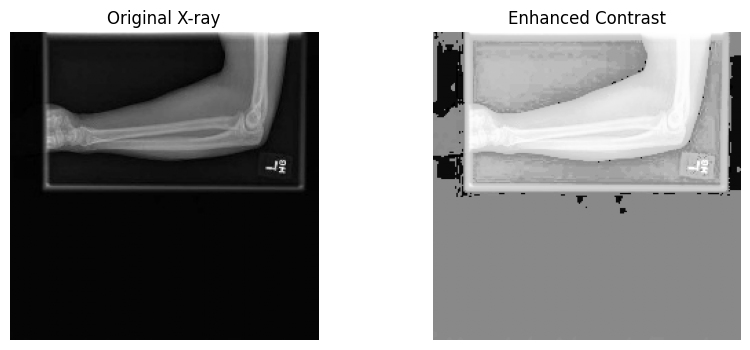


Image: image1_195_png.rf.11933f3b51216212abd53a1a6014c5ad.jpg
Size: (224, 224) (height, width)
Intensity - Min: 0, Max: 240, Avg: 3.0


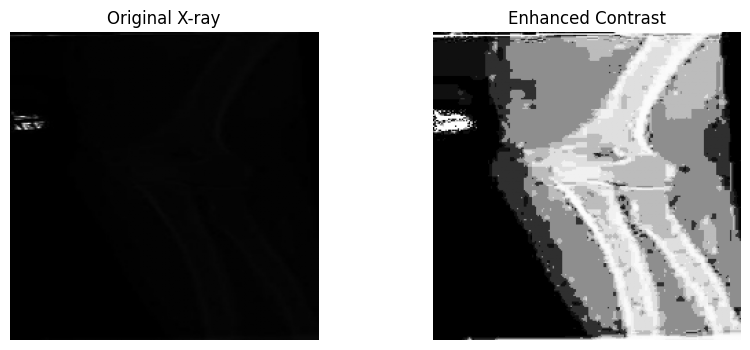


Checking label files...
image1_4982_png.rf.de955dbcc180717b2fd57637e3a25202.txt: 1 fracture(s) found
image1_3519_png.rf.7f5cfa925c14b56c6d38a953b66dbe84.txt: 1 fracture(s) found
image1_1447_png.rf.708f77c92737077936f2bd63a7736134_aug0.txt: 1 fracture(s) found
image2_693_png.rf.28c48dcaa556da824f72a0b0f859ca03.txt: 2 fracture(s) found
image1_1087_png.rf.6fc39035a81b57c1d60891a300156355.txt: 0 fracture(s) found
image1_7603_png.rf.5766c774928ee1823cee08424fa508db_aug0.txt: 1 fracture(s) found
image1_589_png.rf.3263943152bf4b80e684254c2326468b_aug0.txt: 2 fracture(s) found
image1_964_png.rf.6c2a9c8b336daa48257ead4ab986c751.txt: 2 fracture(s) found
image1_376_png.rf.cc7dc108ec6db52da50bd7e902713305.txt: 0 fracture(s) found
image1_195_png.rf.11933f3b51216212abd53a1a6014c5ad.txt: 0 fracture(s) found


In [40]:
# 1. Basic Setup

image_folder = train_images_path
all_images = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')]
image_paths = random.sample(all_images, 10)

# 2. Simple Image Analysis
for img_path in image_paths:
    # Load image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale

    if img is None:
        print(f"Couldn't read {img_path}")
        continue

    # Basic stats
    print(f"\nImage: {os.path.basename(img_path)}")
    print(f"Size: {img.shape} (height, width)")
    print(f"Intensity - Min: {np.min(img)}, Max: {np.max(img)}, Avg: {np.mean(img):.1f}")

    # Simple display
    plt.figure(figsize=(10,4))

    # Original image
    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray')
    plt.title("Original X-ray")
    plt.axis('off')

    # Enhanced image (better for seeing fractures)
    plt.subplot(1,2,2)
    enhanced = cv2.equalizeHist(img)  # Simple contrast enhancement
    plt.imshow(enhanced, cmap='gray')
    plt.title("Enhanced Contrast")
    plt.axis('off')

    plt.show()

# 3. Check Label Files (if available)
label_folder = image_folder.replace("images", "labels")
if os.path.exists(label_folder):
    print("\nChecking label files...")
    for img_path in image_paths:
        base_name = os.path.basename(img_path).replace('.jpg', '.txt')
        label_path = os.path.join(label_folder, base_name)

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                labels = f.readlines()
            print(f"{base_name}: {len(labels)} fracture(s) found")
        else:
            print(f"{base_name}: No label file found")

# Augmenttion for CNN

In [65]:
aug_images_path = os.path.join(data_path, 'aug_images')
aug_labels_path = os.path.join(data_path, 'aug_labels')
os.makedirs(aug_images_path, exist_ok=True)
os.makedirs(aug_labels_path, exist_ok=True)

# Augmentation pipeline with bboxes
transform = A.Compose([
    A.HorizontalFlip(p=1.0),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=15, p=0.4),
    #A.RandomScale(scale_limit=0.1, p=0.3),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.3, filter_invalid_bboxes = True))

# loop on all class 3 images
for label_file in os.listdir(train_label_path):
    label_path = os.path.join(train_label_path, label_file)
    with open(label_path, 'r') as f:
        lines = f.readlines()

    #  filter boxes with class 3
    class_labels = []
    bboxes = []
    for line in lines:
        parts = line.strip().split()
        if parts[0] == '3':
            class_labels.append(3)
            bbox = list(map(float, parts[1:]))  # YOLO: x_center y_center width height
            bboxes.append(bbox)

    if not bboxes:   # If haven't class 3
        continue

    #  read the image
    image_file = label_file.replace('.txt', '.jpg')
    image_path = os.path.join(train_images_path, image_file)
    if not os.path.exists(image_path):
        continue

    image = cv2.imread(image_path)

    for i in range(70):  # augment 70 times
        transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_img = transformed['image']
        aug_bboxes = transformed['bboxes']

        new_img_name = f'aug_{i}_{image_file}'
        new_label_name = f'aug_{i}_{label_file}'

        #  Save the new image
        cv2.imwrite(os.path.join(aug_images_path, new_img_name), aug_img)

        #  Save the new label
        with open(os.path.join(aug_labels_path, new_label_name), 'w') as f:
            for bbox in aug_bboxes:
                f.write(f"3 {' '.join(map(str, bbox))}\n")

# CNN

In [66]:
#Create csv files
def create_label_csvs(dataset_path, output_path, no_fracture_class_id=7):
    # Define folders
    splits = ['train', 'valid', 'test']
    
    for split in splits:
        # Paths to images and labels
        image_folder = os.path.join(dataset_path, split, 'images')
        label_folder = os.path.join(dataset_path, split, 'labels')
        
        # Check if folders exist
        if not os.path.exists(image_folder) or not os.path.exists(label_folder):
            print(f"Warning: {image_folder} or {label_folder} does not exist. Skipping {split}...")
            continue
        
        # Get list of image files
        image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]
        print(f"Processing {len(image_files)} images in {split}...")
        
        # Initialize lists for CSV
        image_names = []
        class_ids = []
        
        for image_file in image_files:
            # Corresponding label file
            label_file = os.path.splitext(image_file)[0] + '.txt'
            label_path = os.path.join(label_folder, label_file)
            
            # Default class_id for empty or missing labels
            class_id = no_fracture_class_id
            
            # Check if label file exists
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                
                # Check if file is not empty
                if lines:
                    # Take class_id from the first line
                    first_line = lines[0].strip()
                    if first_line:
                        try:
                            parts = first_line.split()
                            if parts and len(parts) > 0:
                                class_id = int(parts[0])  # Convert to int
                                # Validate class_id
                                if class_id < 0 or class_id > 6:
                                    print(f"Warning: Invalid class_id {class_id} in {label_path}. Using no_fracture_class_id...")
                                    class_id = no_fracture_class_id
                            # else:
                            #     print(f"Warning: Empty or invalid line in {label_path}. Using no_fracture_class_id...")
                        except ValueError as e:
                            print(f"Warning: Error parsing class_id in {label_path}: {e}. Using no_fracture_class_id...")
                    # else:
                    #     print(f"Warning: First line is empty in {label_path}. Using no_fracture_class_id...")
                # else:
                #     print(f"Warning: Label file {label_path} is empty. Using no_fracture_class_id...")
            else:
                print(f"Warning: Label file {label_path} not found. Using no_fracture_class_id...")
            
            # Add to lists
            image_names.append(image_file)
            class_ids.append(class_id)
        
        # Create DataFrame
        df = pd.DataFrame({
            'image_name': image_names,
            'class_id': class_ids
        })
        
        # Save to CSV
        csv_path = os.path.join(output_path, f'{split}_labels.csv')
        df.to_csv(csv_path, index=False)
        print(f"Saved {split}_labels.csv with {len(df)} entries at {csv_path}")

In [67]:
# usage of create_label_csvs func
dataset_path = data_path  # Path to dataset
output_path = "final_bones/BoneFractureYolo8_final/labels_csv"  # Where to save CSVs
os.makedirs(output_path, exist_ok=True)  # Create output directory if it doesn't exist
create_label_csvs(dataset_path, output_path, no_fracture_class_id=7)

Processing 3631 images in train...
Saved train_labels.csv with 3631 entries at final_bones/BoneFractureYolo8_final/labels_csv\train_labels.csv
Processing 348 images in valid...
Saved valid_labels.csv with 348 entries at final_bones/BoneFractureYolo8_final/labels_csv\valid_labels.csv
Processing 169 images in test...
Saved test_labels.csv with 169 entries at final_bones/BoneFractureYolo8_final/labels_csv\test_labels.csv


## Build the model

In [68]:
def build_efficientnet_b0(num_classes=8, input_shape=(224, 224, 3), freeze_backbone=True):
    # Load EfficientNet-B0 with pre-trained ImageNet weights
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the backbone layers if specified
    if freeze_backbone:
        for layer in base_model.layers:
            layer.trainable = False
    
    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Convert features to a single vector
    x = Dense(512, activation='relu')(x)  # Add a dense layer
    x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
    predictions = Dense(num_classes, activation='softmax')(x)  # Output layer for 8 classes
    
    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Example usage
model = build_efficientnet_b0(num_classes=8, input_shape=(224, 224, 3), freeze_backbone=True)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step 


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,709,547 (17.97 MB)

 Trainable params: 659,976 (2.52 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [74]:
def convert_class_id_to_strings(csv_path):
    # Define CSV files
    splits = ['train_labels.csv', 'valid_labels.csv', 'test_labels.csv']
    
    for csv_file in splits:
        csv_file_path = os.path.join(csv_path, csv_file)
        
        # Check if CSV exists
        if not os.path.exists(csv_file_path):
            print(f"Warning: {csv_file_path} not found. Skipping...")
            continue
        
        # Read CSV
        df = pd.read_csv(csv_file_path)
        
        # Check column name and data
        if 'class_id' not in df.columns:
            print(f"Error: 'class_id' column not found in {csv_file_path}. Columns: {df.columns}")
            continue
        
        # Convert class_id to strings explicitly
        df['class_id'] = df['class_id'].astype(str)
        
        # Verify conversion in DataFrame
        print(f"Before saving {csv_file}: class_id dtype = {df['class_id'].dtype}")
        print(f"Sample class_id values: {df['class_id'].head().tolist()}")
        
        # Save to a new CSV file with '_modified' suffix
        new_csv_file = csv_file.replace('.csv', '_modified.csv')
        new_csv_file_path = os.path.join(csv_path, new_csv_file)
        df.to_csv(new_csv_file_path, index=False, quoting=csv.QUOTE_ALL)
        
        # Verify the saved CSV
        # Read with dtype to force class_id as string
        saved_df = pd.read_csv(new_csv_file_path, dtype={'class_id': str})
        print(f"After saving {new_csv_file}: class_id dtype = {saved_df['class_id'].dtype}")
        print(f"Sample class_id values in saved file: {saved_df['class_id'].head().tolist()}")
        
        # Check raw CSV content
        with open(new_csv_file_path, 'r') as f:
            lines = f.readlines()[:6]  # Read first 5 rows + header
            print(f"Raw CSV content (first 5 rows) for {new_csv_file}:\n{''.join(lines)}")
        
        print(f"Converted class_id to strings and saved to {new_csv_file_path}")

# Example usage
csv_path = "final_bones/BoneFractureYolo8_final/labels_csv"  # Path to your CSV files
convert_class_id_to_strings(csv_path)

Before saving train_labels.csv: class_id dtype = object
Sample class_id values: ['0', '0', '0', '0', '0']
After saving train_labels_modified.csv: class_id dtype = object
Sample class_id values in saved file: ['0', '0', '0', '0', '0']
Raw CSV content (first 5 rows) for train_labels_modified.csv:
"image_name","class_id"
"distal-humeral-fractures-2-_JPEG.rf.39ba3f53047ecb4064613850a1c76fc1.jpg","0"
"distal-humeral-fractures-2-_JPEG.rf.525ce876785d0fd798ec3af1593e5bc1.jpg","0"
"distal-humeral-fractures-2-_JPEG.rf.f9442db05ec473187c60870d407c9e8f.jpg","0"
"elbow-dislocation-with-coronoid-process-fracture_jpg.rf.234153519323ba2b9aa2e603b0a43771.jpg","0"
"elbow-dislocation-with-coronoid-process-fracture_jpg.rf.75b67d2e40fe637ba2838e1283f970c5.jpg","0"

Converted class_id to strings and saved to final_bones/BoneFractureYolo8_final/labels_csv\train_labels_modified.csv
Before saving valid_labels.csv: class_id dtype = object
Sample class_id values: ['0', '1', '1', '7', '7']
After saving valid_lab

renamed the files.csv

In [75]:
csv_path = "final_bones/BoneFractureYolo8_final/labels_csv"
modified_csv = pd.read_csv(f"{csv_path}/train_labels.csv", dtype={'class_id': str})
print("Columns:", modified_csv.columns)
print("First 5 rows:\n", modified_csv.head())
print("class_id dtype:", modified_csv['class_id'].dtype)
print("Unique class_id values:", modified_csv['class_id'].unique())
print("Any null values in class_id?", modified_csv['class_id'].isnull().any())

Columns: Index(['image_name', 'class_id'], dtype='object')
First 5 rows:
                                           image_name class_id
0  distal-humeral-fractures-2-_JPEG.rf.39ba3f5304...        0
1  distal-humeral-fractures-2-_JPEG.rf.525ce87678...        0
2  distal-humeral-fractures-2-_JPEG.rf.f9442db05e...        0
3  elbow-dislocation-with-coronoid-process-fractu...        0
4  elbow-dislocation-with-coronoid-process-fractu...        0
class_id dtype: object
Unique class_id values: ['0' '7' '5' '6' '4' '2' '1']
Any null values in class_id? False


In [79]:
#pipeline
def create_data_pipeline(dataset_path, csv_path, image_size=(224, 224), batch_size=16, num_classes=8):
    # Load CSV files
    train_csv = os.path.join(csv_path, 'train_labels.csv')
    valid_csv = os.path.join(csv_path, 'valid_labels.csv')
    test_csv = os.path.join(csv_path, 'test_labels.csv')
    
    # Check if CSV files exist
    for csv_file in [train_csv, valid_csv, test_csv]:
        if not os.path.exists(csv_file):
            raise FileNotFoundError(f"CSV file {csv_file} not found")
    
    # Read CSVs
    train_df = pd.read_csv(train_csv)
    valid_df = pd.read_csv(valid_csv)
    test_df = pd.read_csv(test_csv)
    
    # Define image directories
    train_dir = os.path.join(dataset_path, 'train', 'images')
    valid_dir = os.path.join(dataset_path, 'valid', 'images')
    test_dir = os.path.join(dataset_path, 'test', 'images')
    
    # Verify directories exist
    for dir_path in [train_dir, valid_dir, test_dir]:
        if not os.path.exists(dir_path):
            raise FileNotFoundError(f"Image directory {dir_path} not found")
    
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,  # Normalization for EfficientNet
        rotation_range=20,                       # Random rotation ±20 degrees
        width_shift_range=0.2,                   # Horizontal shift ±20% of width
        height_shift_range=0.2,                  # Vertical shift ±20% of height
        horizontal_flip=True,                    # Random horizontal flip
        zoom_range=0.2,                         # Random zoom ±20%
        shear_range=0.2,                        # Shear transformation ±20%
        fill_mode='nearest'                     # Fill pixels after transformations
    )
    
    # Only normalization for validation and test
    valid_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )
    test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )
    
    # Create data generators
    train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(train_csv, dtype={'class_id': str}),
    directory=train_dir,
    x_col='image_name',
    y_col='class_id',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    validate_filenames=True
)

    valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(valid_csv, dtype={'class_id': str}),
    directory=valid_dir,
    x_col='image_name',
    y_col='class_id',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    validate_filenames=True
)
    

    test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(test_csv, dtype={'class_id': str}),
    directory=test_dir,
    x_col='image_name',
    y_col='class_id',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    validate_filenames=True
)
    

    
    return train_generator, valid_generator, test_generator

# Example usage
dataset_path = "final_bones/BoneFractureYolo8_final"  # Path to dataset
csv_path = "final_bones/BoneFractureYolo8_final/labels_csv"  # Path to CSV files
image_size = (224, 224)
batch_size = 16
num_classes = 8

train_generator, valid_generator, test_generator = create_data_pipeline(
    dataset_path=dataset_path,
    csv_path=csv_path,
    image_size=image_size,
    batch_size=batch_size,
    num_classes=num_classes
)

Found 3631 validated image filenames belonging to 7 classes.
Found 348 validated image filenames belonging to 7 classes.
Found 169 validated image filenames belonging to 7 classes.


In [82]:
# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Define paths (same as in your data pipeline)
csv_path = "final_bones/BoneFractureYolo8_final/labels_csv"
train_csv = os.path.join(csv_path, 'train_labels.csv')
valid_csv = os.path.join(csv_path, 'valid_labels.csv')
dataset_path = "final_bones/BoneFractureYolo8_final"
train_dir = os.path.join(dataset_path, 'train/images')
valid_dir = os.path.join(dataset_path, 'valid/images')

# Image parameters (same as in your data pipeline)
image_size = (224, 224)
batch_size = 16
num_classes = 8

# Calculate class weights to handle class imbalance
def compute_class_weights(csv_file):
    df = pd.read_csv(csv_file, dtype={'class_id': str})
    class_counts = df['class_id'].value_counts()
    total_samples = len(df)
    class_weights = {}
    for class_id, count in class_counts.items():
        class_weights[int(class_id)] = (1 / count) * (total_samples / num_classes)
    return class_weights

class_weights = compute_class_weights(train_csv)
print("Class weights:", class_weights)

# Load the data generators (same as your data pipeline, with dtype={'class_id': str})
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(train_csv, dtype={'class_id': str}),
    directory=train_dir,
    x_col='image_name',
    y_col='class_id',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    validate_filenames=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(valid_csv, dtype={'class_id': str}),
    directory=valid_dir,
    x_col='image_name',
    y_col='class_id',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    validate_filenames=True
)

# Load EfficientNet-B0 with pre-trained ImageNet weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Part 1: Train only the top layers (freeze base model)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

checkpoint = ModelCheckpoint(
    'final_bones/BoneFractureYolo8_final/model_checkpoint.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Train the top layers
print("Training top layers...")
history_phase1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler, checkpoint],
    verbose=1
)

Num GPUs Available:  0
Class weights: {7: 0.2484263820470717, 1: 1.0482101616628174, 5: 1.4408730158730159, 0: 1.4832516339869282, 4: 1.5179765886287626, 2: 1.6037985865724382, 6: 2.7016369047619047}
Found 3631 validated image filenames belonging to 7 classes.
Found 348 validated image filenames belonging to 7 classes.
Training top layers...


C:\miniconda\condainstall\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 95s 378ms/step - accuracy: 0.4965 - loss: 2.5874 - val_accuracy: 0.5208 - val_loss: 1.5608 - learning_rate: 0.0010
Epoch 2/10
  1/226 ━━━━━━━━━━━━━━━━━━━━ 58s 259ms/step - accuracy: 0.6250 - loss: 2.2946

C:\miniconda\condainstall\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6250 - loss: 2.2946 - val_accuracy: 0.5208 - val_loss: 1.5602 - learning_rate: 0.0010
Epoch 3/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 85s 374ms/step - accuracy: 0.5088 - loss: 2.4630 - val_accuracy: 0.5208 - val_loss: 1.6158 - learning_rate: 0.0010
Epoch 4/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4375 - loss: 2.7688 - val_accuracy: 0.5208 - val_loss: 1.6034 - learning_rate: 0.0010
Epoch 5/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 83s 367ms/step - accuracy: 0.5122 - loss: 2.4301 - val_accuracy: 0.5208 - val_loss: 1.5683 - learning_rate: 0.0010
Epoch 6/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.3750 - loss: 2.8428 - val_accuracy: 0.5208 - val_loss: 1.5694 - learning_rate: 5.0000e-04
Epoch 7/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 83s 369ms/step - accuracy: 0.5072 - loss: 2.4358 - val_accuracy: 0.5208 - val_loss: 1.5650 - learning_rate: 5.0000e-04


In [88]:
# Part 2: Fine-tune some top layers
# Unfreeze the top 30 layers of the base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
print("Fine-tuning top layers...")
history_phase2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler, checkpoint],
    verbose=1
)

# Save the final model
model.save('final_bones/BoneFractureYolo8_final/final_model.h5')
print("Final model saved!")

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(valid_generator)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Fine-tuning top layers...
Epoch 1/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 104s 404ms/step - accuracy: 0.5061 - loss: 2.4607 - val_accuracy: 0.5208 - val_loss: 1.6653 - learning_rate: 1.0000e-04
Epoch 2/15
  1/226 ━━━━━━━━━━━━━━━━━━━━ 1:10 311ms/step - accuracy: 0.4375 - loss: 2.5924

C:\miniconda\condainstall\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4375 - loss: 2.5924 - val_accuracy: 0.5208 - val_loss: 1.6587 - learning_rate: 1.0000e-04
Epoch 3/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 90s 398ms/step - accuracy: 0.5054 - loss: 2.4435 - val_accuracy: 0.5208 - val_loss: 1.5729 - learning_rate: 1.0000e-04
Epoch 4/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5000 - loss: 2.2709 - val_accuracy: 0.5208 - val_loss: 1.5724 - learning_rate: 1.0000e-04
Epoch 5/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 91s 401ms/step - accuracy: 0.4901 - loss: 2.4790 - val_accuracy: 0.5208 - val_loss: 1.6155 - learning_rate: 1.0000e-04
Epoch 6/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.4375 - loss: 2.8430 - val_accuracy: 0.5208 - val_loss: 1.6120 - learning_rate: 1.0000e-04
Epoch 7/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 90s 399ms/step - accuracy: 0.5021 - loss: 2.4376 - val_accuracy: 0.5208 - val_loss: 1.6226 - learning_rate: 1.0000e-04
Epoch 8/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy

Final model saved!
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 251ms/step - accuracy: 0.5287 - loss: 1.5672
Validation Loss: 1.6173, Validation Accuracy: 0.5029


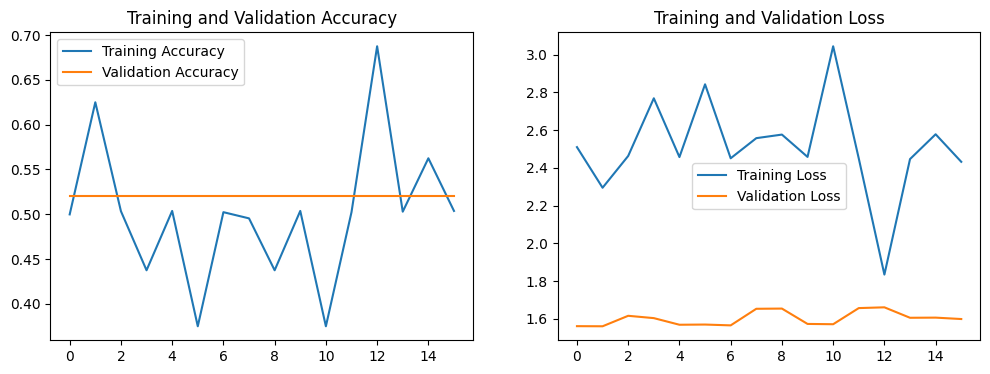

In [85]:
#Plot training history
import matplotlib.pyplot as plt

def plot_training_history(history_phase1, history_phase2):
    acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
    val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
    loss = history_phase1.history['loss'] + history_phase2.history['loss']
    val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.show()

plot_training_history(history_phase1, history_phase2)

# YOLO

In [96]:
# To know if the images are one size
sizes = []
for folder in os.listdir(train_path):
    images = gb.glob(pathname = str(train_path + '/' + folder + '/*.jpg'))

    for img in images:
        image = plt.imread(img)
        sizes.append(image.shape)

pd.Series(sizes).value_counts()

(224, 224, 3)    3631
Name: count, dtype: int64

Delete class 3 images

In [100]:

train_labels_path = train_label_path
class_3_files = []

for label_file in os.listdir(train_labels_path):
    if label_file.endswith(".txt"):
        with open(os.path.join(train_labels_path, label_file), "r") as f:
            lines = f.readlines()
            for line in lines:
                if line.strip().startswith("3 "):
                    class_3_files.append(label_file)
                    break

print(f"Found {len(class_3_files)} files with class 3: {class_3_files}")

Found 3 files with class 3: ['image1_10_png.rf.5d88c6ee8fb853152b37b10a2b28732c.txt', 'image1_10_png.rf.b8ccafbb00304e90bd5e7720351bca10.txt', 'image1_10_png.rf.ead613f61199210119d086b6af5859e7.txt']


In [101]:
train_images_path = train_images_path
for label_file in class_3_files:
    # Delete label files
    label_path = os.path.join(train_labels_path, label_file)
    if os.path.exists(label_path):
        os.remove(label_path)
        print(f"Deleted label: {label_path}")

    # Delete its images
    image_file = label_file.replace(".txt", ".jpg") 
    image_path = os.path.join(train_images_path, image_file)
    if os.path.exists(image_path):
        os.remove(image_path)
        print(f"Deleted image: {image_path}")

Deleted label: final_bones/BoneFractureYolo8_final/train/labels\image1_10_png.rf.5d88c6ee8fb853152b37b10a2b28732c.txt
Deleted image: final_bones/BoneFractureYolo8_final/train/images\image1_10_png.rf.5d88c6ee8fb853152b37b10a2b28732c.jpg
Deleted label: final_bones/BoneFractureYolo8_final/train/labels\image1_10_png.rf.b8ccafbb00304e90bd5e7720351bca10.txt
Deleted image: final_bones/BoneFractureYolo8_final/train/images\image1_10_png.rf.b8ccafbb00304e90bd5e7720351bca10.jpg
Deleted label: final_bones/BoneFractureYolo8_final/train/labels\image1_10_png.rf.ead613f61199210119d086b6af5859e7.txt
Deleted image: final_bones/BoneFractureYolo8_final/train/images\image1_10_png.rf.ead613f61199210119d086b6af5859e7.jpg


In [142]:
# know the number of images each class has
class_ids = []

for filename in os.listdir(train_label_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(train_label_path, filename)
        with open(file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.strip():  # make sure that the line is not empty
                    class_id = int(line.strip().split()[0])  
                    class_ids.append(class_id)

df = pd.DataFrame(class_ids, columns=['class_id'])
counts = df['class_id'].value_counts().sort_index()

print(counts)

class_id
0    339
1    531
2    316
4    308
5    360
6    228
Name: count, dtype: int64


Augmentation

In [143]:
import os
import cv2
import numpy as np
import albumentations as A

# تحديد المسارات
train_images_path = 'final_bones/BoneFractureYolo8_final/train/images'
train_labels_path = 'final_bones/BoneFractureYolo8_final/train/labels'
output_images_path = "final_bones/BoneFractureYolo8_final/augmented/images"
output_labels_path = "final_bones/BoneFractureYolo8_final/augmented/labels"
os.makedirs(output_images_path, exist_ok=True)
os.makedirs(output_labels_path, exist_ok=True)              #xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

# تحديد الكلاسات الصغيرة
small_classes = [0, 2, 4, 5, 6]
target_count = 600
class_counts = {0: 339, 1: 531, 2: 316, 4: 308, 5: 360, 6: 228}

# إعداد الـ Augmentation (فصل التحويلات)
geometric_transforms = A.Compose([
    A.Rotate(limit=15, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomScale(scale_limit=0.1, p=0.3),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

appearance_transforms = A.Compose([
    A.RandomBrightnessContrast(p=0.3),
])

# دالة لقراءة الـ labels
def read_label(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    annotations = []
    for line in lines:
        parts = line.strip().split()
        if not parts:
            continue
        class_id = int(parts[0])
        coords = list(map(float, parts[1:]))
        keypoints = [(coords[i], coords[i+1]) for i in range(0, len(coords), 2)]
        annotations.append({'class_id': class_id, 'keypoints': keypoints})
    return annotations

# دالة لحفظ الـ labels
def save_label(label_path, annotations):
    with open(label_path, 'w') as f:
        for ann in annotations:
            class_id = ann['class_id']
            keypoints = ann['keypoints']
            coords = []
            for x, y in keypoints:
                x = max(0, min(1, x))
                y = max(0, min(1, y))
                coords.extend([x, y])
            f.write(f"{class_id} {' '.join(map(str, coords))}\n")

# دالة لتطبيق Augmentation
def augment_images_and_labels(image_path, label_path, output_image_path, output_label_path, num_augmentations):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Cannot read image: {image_path}")
        return
    annotations = read_label(label_path)
    h, w = img.shape[:2]
    for i in range(num_augmentations):
        # تحضير الـ keypoints
        keypoints = []
        keypoint_counts = []
        for ann in annotations:
            keypoints.extend([(x * w, y * h) for x, y in ann['keypoints']])
            keypoint_counts.append(len(ann['keypoints']))
        # تطبيق التحويلات الهندسية
        transformed = geometric_transforms(image=img, keypoints=keypoints)
        aug_img = transformed['image']
        aug_keypoints = transformed['keypoints']
        # تطبيق التحويلات غير الهندسية
        aug_img = appearance_transforms(image=aug_img)['image']
        aug_h, aug_w = aug_img.shape[:2]
        # إعادة تجميع الـ annotations
        aug_annotations = []
        kp_idx = 0
        for count in keypoint_counts:
            aug_kp = []
            for j in range(count):
                if kp_idx + j < len(aug_keypoints):
                    x, y = aug_keypoints[kp_idx + j]
                    aug_kp.append((x / aug_w, y / aug_h))
                else:
                    print(f"Warning: Missing keypoint for {image_path}")
                    aug_kp.append((0, 0))
            kp_idx += count
            aug_annotations.append({
                'class_id': annotations[len(aug_annotations)]['class_id'],
                'keypoints': aug_kp
            })
        # فحص عدد النقاط
        for ann, orig_ann in zip(aug_annotations, annotations):
            if len(ann['keypoints']) != len(orig_ann['keypoints']):
                print(f"Error: Mismatch in keypoint count for {image_path}")
        # فحص الإحداثيات
        for ann in aug_annotations:
            for x, y in ann['keypoints']:
                if not (0 <= x <= 1 and 0 <= y <= 1):
                    print(f"Warning: Invalid coordinate ({x}, {y}) in {output_label_path}")
        # حفظ الصورة والـ label
        aug_image_path = output_image_path.replace('.jpg', f'_aug{i}.jpg')
        aug_label_path = output_label_path.replace('.txt', f'_aug{i}.txt')
        cv2.imwrite(aug_image_path, aug_img)
        save_label(aug_label_path, aug_annotations)
        print(f"Saved augmented image: {aug_image_path}")
        print(f"Saved augmented label: {aug_label_path}")

# معالجة الصور
for label_file in os.listdir(train_labels_path):
    if label_file.endswith('.txt'):
        label_path = os.path.join(train_labels_path, label_file)
        annotations = read_label(label_path)
        if not annotations:
            continue
        class_ids = set(ann['class_id'] for ann in annotations)
        if any(class_id in small_classes for class_id in class_ids):
            image_file = label_file.replace('.txt', '.jpg')  # أو .png
            image_path = os.path.join(train_images_path, image_file)
            if os.path.exists(image_path):
                relevant_classes = [cid for cid in class_ids if cid in small_classes]
                if relevant_classes:
                    min_class = min(relevant_classes, key=lambda x: class_counts[x])
                    current_count = class_counts[min_class]
                    augmentations_needed = max(0, target_count - current_count)
                    num_augmentations = augmentations_needed // current_count + 1
                    augment_images_and_labels(
                        image_path,
                        label_path,
                        os.path.join(output_images_path, image_file),
                        os.path.join(output_labels_path, label_file),
                        num_augmentations
                    )
                    for class_id in class_ids:
                        if class_id in class_counts:
                            class_counts[class_id] += num_augmentations

print("Augmentation completed. Updated class counts:", class_counts)

Saved augmented image: final_bones/BoneFractureYolo8_final/augmented/images\distal-humeral-fractures-2-_JPEG.rf.39ba3f53047ecb4064613850a1c76fc1_aug0.jpg
Saved augmented label: final_bones/BoneFractureYolo8_final/augmented/labels\distal-humeral-fractures-2-_JPEG.rf.39ba3f53047ecb4064613850a1c76fc1_aug0.txt
Saved augmented image: final_bones/BoneFractureYolo8_final/augmented/images\distal-humeral-fractures-2-_JPEG.rf.525ce876785d0fd798ec3af1593e5bc1_aug0.jpg
Saved augmented label: final_bones/BoneFractureYolo8_final/augmented/labels\distal-humeral-fractures-2-_JPEG.rf.525ce876785d0fd798ec3af1593e5bc1_aug0.txt
Saved augmented image: final_bones/BoneFractureYolo8_final/augmented/images\distal-humeral-fractures-2-_JPEG.rf.f9442db05ec473187c60870d407c9e8f_aug0.jpg
Saved augmented label: final_bones/BoneFractureYolo8_final/augmented/labels\distal-humeral-fractures-2-_JPEG.rf.f9442db05ec473187c60870d407c9e8f_aug0.txt
Saved augmented image: final_bones/BoneFractureYolo8_final/augmented/images\

In [163]:
#COPY AUGMENTED IMAGES AND LABELS 

# paths
augmented_images_path = "final_bones/BoneFractureYolo8_final/augmented/images"
augmented_labels_path = "final_bones/BoneFractureYolo8_final/augmented/labels"
train_images_path = "final_bones/BoneFractureYolo8_final/train/images"
train_labels_path = "final_bones/BoneFractureYolo8_final/train/labels"


os.makedirs(train_images_path, exist_ok=True)
os.makedirs(train_labels_path, exist_ok=True)


for image_file in os.listdir(augmented_images_path):
    if image_file.endswith(('.jpg')):  
        src = os.path.join(augmented_images_path, image_file)
        dst = os.path.join(train_images_path, image_file)
        shutil.copy(src, dst)
        print(f"Copied: {dst}")


for label_file in os.listdir(augmented_labels_path):
    if label_file.endswith('.txt'):
        src = os.path.join(augmented_labels_path, label_file)
        dst = os.path.join(train_labels_path, label_file)
        shutil.copy(src, dst)
        print(f"Copied: {dst}")

Copied: final_bones/BoneFractureYolo8_final/train/images\distal-humeral-fractures-2-_JPEG.rf.39ba3f53047ecb4064613850a1c76fc1_aug0.jpg
Copied: final_bones/BoneFractureYolo8_final/train/images\distal-humeral-fractures-2-_JPEG.rf.525ce876785d0fd798ec3af1593e5bc1_aug0.jpg
Copied: final_bones/BoneFractureYolo8_final/train/images\distal-humeral-fractures-2-_JPEG.rf.f9442db05ec473187c60870d407c9e8f_aug0.jpg
Copied: final_bones/BoneFractureYolo8_final/train/images\elbow-dislocation-with-coronoid-process-fracture_jpg.rf.234153519323ba2b9aa2e603b0a43771_aug0.jpg
Copied: final_bones/BoneFractureYolo8_final/train/images\elbow-dislocation-with-coronoid-process-fracture_jpg.rf.75b67d2e40fe637ba2838e1283f970c5_aug0.jpg
Copied: final_bones/BoneFractureYolo8_final/train/images\elbow-dislocation-with-coronoid-process-fracture_jpg.rf.76486fb6ffe2b6c7da0e4922e58a088f_aug0.jpg
Copied: final_bones/BoneFractureYolo8_final/train/images\fracture-of-the-humeral-capitellum-milch-type-1-1-1-_jpg.rf.4c16d0817782b

In [167]:
# know the number of images each class has
class_ids = []

for filename in os.listdir(train_label_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(train_label_path, filename)
        with open(file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.strip():  # make sure that the line is not empty
                    class_id = int(line.strip().split()[0])  
                    class_ids.append(class_id)

df = pd.DataFrame(class_ids, columns=['class_id'])
counts = df['class_id'].value_counts().sort_index()

print(counts)

class_id
0    678
1    531
2    632
4    616
5    720
6    505
Name: count, dtype: int64


In [168]:
import os

def count_files(path, extensions):
    return len([f for f in os.listdir(path) if f.endswith(extensions)])


print(f"Train images: {count_files(train_images_path, ('.jpg', '.png'))}")
print(f"Train labels: {count_files(train_label_path, ('.txt'))}")
print(f"Valid images: {count_files(valid_images_path, ('.jpg', '.png'))}")
print(f"Valid labels: {count_files(valid_labels_path, ('.txt'))}")

Train images: 5033
Train labels: 5033
Valid images: 348
Valid labels: 348


convert class 6 to class 3

In [8]:
import os
def update_labels(labels_path):
    updated_files = []
    for label_file in os.listdir(labels_path):
        if label_file.endswith('.txt'):
            with open(os.path.join(labels_path, label_file), 'r') as f:
                lines = f.readlines()
            modified = False
            new_lines = []
            for line in lines:
                parts = line.split()
                class_id = int(parts[0])
                if class_id == 6:
                    new_lines.append(f"3 {' '.join(parts[1:])}\n")
                    modified = True
                else:
                    new_lines.append(line)
            if modified:
                with open(os.path.join(labels_path, label_file), 'w') as f:
                    f.writelines(new_lines)
                updated_files.append(label_file)
    return updated_files

print("Updated train labels:", update_labels(train_label_path))
print("Updated valid labels:", update_labels(valid_labels_path))
print("Updated valid labels:", update_labels(test_label_path))

Updated train labels: ['image1_1002_png.rf.1feafce607366113c97124dc22d52328.txt', 'image1_1002_png.rf.1feafce607366113c97124dc22d52328_aug0.txt', 'image1_1002_png.rf.1feafce607366113c97124dc22d52328_aug1.txt', 'image1_1002_png.rf.67c46c90c7089ef2ffa40b5fa22e4ad1.txt', 'image1_1002_png.rf.67c46c90c7089ef2ffa40b5fa22e4ad1_aug0.txt', 'image1_1002_png.rf.67c46c90c7089ef2ffa40b5fa22e4ad1_aug1.txt', 'image1_1002_png.rf.c94d11a79032d6beb4ce4d876c9f7fda.txt', 'image1_1002_png.rf.c94d11a79032d6beb4ce4d876c9f7fda_aug0.txt', 'image1_1002_png.rf.c94d11a79032d6beb4ce4d876c9f7fda_aug1.txt', 'image1_1022_png.rf.077dcb969ab7f549f7bc09bddca07895.txt', 'image1_1022_png.rf.077dcb969ab7f549f7bc09bddca07895_aug0.txt', 'image1_1022_png.rf.077dcb969ab7f549f7bc09bddca07895_aug1.txt', 'image1_1022_png.rf.8bb506fab5d76213a035adf3069a821c.txt', 'image1_1022_png.rf.8bb506fab5d76213a035adf3069a821c_aug0.txt', 'image1_1022_png.rf.8bb506fab5d76213a035adf3069a821c_aug1.txt', 'image1_1022_png.rf.9fa19d22112cf8bcdc7904

In [11]:
# know the number of images each class has
class_ids = []

for filename in os.listdir(train_label_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(train_label_path, filename)
        with open(file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.strip():  # make sure that the line is not empty
                    class_id = int(line.strip().split()[0])  
                    class_ids.append(class_id)

df = pd.DataFrame(class_ids, columns=['class_id'])
counts = df['class_id'].value_counts().sort_index()

print(counts)

class_id
0    678
1    531
2    632
3    505
4    616
5    720
Name: count, dtype: int64


# 50 EPOCHS (new)

In [17]:
from ultralytics import YOLO

model = YOLO('yolov8m-seg.pt')  
results3 = model.train(
    data=yaml_path,
    epochs=100,
    imgsz=224,
    batch=16,  
    patience=10,
    device='cuda',
    optimizer='AdamW',
    lr0=0.001,
    cos_lr=True,
    weight_decay=0.001,                
    hsv_h=0.02,
    hsv_s=0.8,
    hsv_v=0.5,
    degrees=5.0,
    mosaic=0.6,
    workers=0,
    task='segment',
    name='bone_fracture_v150'
)                   

New https://pypi.org/project/ultralytics/8.3.123 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.116  Python-3.12.7 torch-2.7.0+cu128 CUDA:0 (Quadro M1000M, 2048MiB)
engine\trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=final_bones/BoneFractureYolo8_final/data.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=cuda, workers=0, project=None, name=bone_fracture_v1502, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sh

train: Scanning C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\train\labels.cache... 5033 ima

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.10.0 ms, read: 53.78.6 MB/s, size: 8.4 KB)



val: Scanning C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\valid\labels.cache... 348 images


Plotting labels to runs\segment\bone_fracture_v1502\labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.001), 96 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs\segment\bone_fracture_v1502
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100       3.6G       3.28      4.326       4.24      2.093          7        224: 100%|██████████| 315/315 [27:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204    0.00316     0.0692    0.00227   0.000661     0.0033     0.0713    0.00336   0.000761



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.58G      3.101      4.114      3.788      1.945          4        224: 100%|██████████| 315/315 [15:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204       0.38       0.05      0.025     0.0062      0.222     0.0935      0.015    0.00374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.57G      3.005      4.037      3.631      1.912          8        224: 100%|██████████| 315/315 [14:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204     0.0779     0.0183      0.022     0.0056      0.018     0.0137     0.0149    0.00353



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.56G      2.962      3.953      3.488      1.866          8        224: 100%|██████████| 315/315 [15:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.601      0.075     0.0413     0.0102      0.602      0.067     0.0437     0.0119



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.56G      2.875      3.908       3.33      1.836          4        224: 100%|██████████| 315/315 [12:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204       0.47      0.087     0.0545     0.0159      0.458     0.0824     0.0441     0.0118



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.55G      2.837      3.884      3.198      1.814         12        224: 100%|██████████| 315/315 [21:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.272      0.105     0.0737     0.0203      0.267     0.0949     0.0566     0.0185



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.55G      2.705      3.779      3.035      1.772          6        224: 100%|██████████| 315/315 [21:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.503        0.1     0.0989     0.0293       0.51     0.0941     0.0924     0.0272



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.55G      2.707      3.736      2.975      1.753         10        224: 100%|██████████| 315/315 [18:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.481      0.125      0.125     0.0419      0.526      0.111      0.115      0.036



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.55G       2.63      3.666      2.863      1.711         10        224: 100%|██████████| 315/315 [18:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.281      0.101      0.092     0.0307      0.279      0.101     0.0864     0.0281



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.55G      2.604      3.646      2.813      1.686          7        224: 100%|██████████| 315/315 [15:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.178      0.151     0.0858     0.0286       0.17      0.124     0.0795     0.0266



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.55G      2.568      3.564      2.675      1.676          7        224: 100%|██████████| 315/315 [20:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.445      0.154      0.114     0.0361      0.444      0.147      0.104     0.0341



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.55G       2.52      3.531      2.616      1.663          8        224: 100%|██████████| 315/315 [19:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.332      0.159      0.133      0.044      0.335      0.155      0.121     0.0404



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.55G       2.49      3.515      2.623      1.639          8        224: 100%|██████████| 315/315 [19:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.167      0.226      0.148     0.0451      0.147      0.201      0.134     0.0439



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.55G      2.453      3.458      2.477      1.613         13        224: 100%|██████████| 315/315 [19:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.171      0.212      0.153      0.049      0.191      0.195       0.15     0.0456



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.55G      2.415      3.388      2.384      1.611          8        224: 100%|██████████| 315/315 [17:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.416      0.189      0.161     0.0542      0.419      0.176      0.157     0.0495



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.55G      2.395      3.369      2.393       1.59          4        224: 100%|██████████| 315/315 [17:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.274      0.213      0.177     0.0585      0.302      0.185      0.164     0.0538



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.55G      2.393      3.372      2.369      1.596          8        224: 100%|██████████| 315/315 [17:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.256      0.206      0.194      0.068       0.53      0.166      0.178     0.0581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.55G       2.33      3.259      2.271      1.559         11        224: 100%|██████████| 315/315 [17:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.472      0.192      0.191     0.0633      0.403      0.188      0.171     0.0523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.55G      2.292      3.242      2.192      1.548          4        224: 100%|██████████| 315/315 [17:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.187      0.206      0.156     0.0564      0.167      0.195      0.144     0.0464



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.55G      2.263      3.189      2.127       1.53         10        224: 100%|██████████| 315/315 [15:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.212        0.2       0.18     0.0614      0.278      0.182      0.177     0.0551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.55G      2.212      3.185      2.085      1.514         12        224: 100%|██████████| 315/315 [20:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.194       0.22      0.181     0.0601      0.166      0.203      0.162     0.0534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.55G      2.233      3.102      2.078      1.504         17        224: 100%|██████████| 315/315 [18:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.263        0.2      0.177     0.0577      0.236      0.186      0.163     0.0503



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.55G      2.162      3.119      2.028      1.481          9        224: 100%|██████████| 315/315 [21:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.404      0.196      0.202     0.0685      0.362      0.213      0.179      0.059



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.55G      2.148      3.083      1.969      1.469         12        224: 100%|██████████| 315/315 [18:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.273      0.247      0.198     0.0612      0.253      0.248      0.182     0.0541



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.55G      2.134      3.046      1.919      1.459          7        224: 100%|██████████| 315/315 [20:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.225      0.248      0.182     0.0562      0.204      0.227       0.16      0.049



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.55G      2.081          3      1.867      1.434         15        224: 100%|██████████| 315/315 [17:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.188      0.242      0.185     0.0668      0.235      0.199      0.178     0.0549



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.55G       2.08      2.979      1.836      1.438          7        224: 100%|██████████| 315/315 [19:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.256      0.238      0.198     0.0738      0.242      0.229      0.196     0.0652



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.55G      2.026      2.956       1.79       1.41         13        224: 100%|██████████| 315/315 [16:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.303      0.276      0.219     0.0746      0.272      0.249      0.207     0.0661



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.55G      2.027      2.913      1.744      1.404          5        224: 100%|██████████| 315/315 [20:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.256      0.264        0.2     0.0704      0.208      0.234      0.174     0.0529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.55G      1.998      2.853      1.681      1.389          8        224: 100%|██████████| 315/315 [18:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.244      0.286      0.214     0.0755      0.247      0.239      0.196     0.0587



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.55G      1.965      2.782       1.64      1.382         12        224: 100%|██████████| 315/315 [18:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.261       0.21      0.206     0.0749      0.223      0.208      0.189      0.059



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.55G      1.916      2.774      1.585      1.361          5        224: 100%|██████████| 315/315 [16:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.385       0.22      0.228     0.0828      0.482      0.185      0.211     0.0725



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.55G      1.907       2.73      1.551      1.352          9        224: 100%|██████████| 315/315 [21:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.428      0.191      0.212     0.0715      0.445      0.206      0.209     0.0663



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.55G      1.904      2.738      1.543      1.347         10        224: 100%|██████████| 315/315 [20:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.327      0.232      0.208     0.0771      0.245      0.208      0.186     0.0676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.55G       1.88      2.711      1.517      1.335         11        224: 100%|██████████| 315/315 [17:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.289      0.244      0.219     0.0694      0.254      0.231      0.188     0.0534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.55G       1.83      2.666      1.468      1.311          6        224: 100%|██████████| 315/315 [14:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.254      0.286      0.217     0.0778      0.218      0.246       0.19     0.0637



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.55G      1.802      2.648      1.444      1.294         11        224: 100%|██████████| 315/315 [17:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.314      0.268      0.223     0.0738      0.256      0.261      0.202     0.0654



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.55G      1.802      2.625       1.42      1.292          7        224: 100%|██████████| 315/315 [18:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204       0.23      0.232      0.202     0.0665      0.254      0.203      0.194     0.0563



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.55G      1.751      2.549      1.367      1.263          6        224: 100%|██████████| 315/315 [17:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.318      0.265      0.223     0.0661      0.295      0.266      0.203     0.0626



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.55G      1.746      2.539      1.326      1.269          9        224: 100%|██████████| 315/315 [17:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.345      0.263      0.231     0.0833      0.332      0.258      0.225     0.0762



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.55G      1.684      2.487       1.29       1.24          6        224: 100%|██████████| 315/315 [15:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.265       0.25      0.212     0.0719      0.251      0.237      0.194     0.0612



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.55G        1.7      2.483      1.276       1.25          5        224: 100%|██████████| 315/315 [21:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.338      0.234      0.208     0.0747      0.303      0.215       0.18     0.0574



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.55G      1.699      2.489      1.302      1.253          7        224: 100%|██████████| 315/315 [22:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.319      0.275      0.236     0.0824      0.277      0.244       0.19     0.0619



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.55G      1.674      2.466      1.258      1.232         16        224: 100%|██████████| 315/315 [22:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.343      0.265      0.208     0.0776      0.335      0.257        0.2     0.0665



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.55G      1.639      2.407      1.228      1.219         11        224: 100%|██████████| 315/315 [22:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.299      0.275      0.207     0.0735      0.267      0.265      0.177     0.0621



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.55G      1.603      2.381      1.187      1.214         13        224: 100%|██████████| 315/315 [19:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.371      0.219      0.216     0.0711      0.357      0.208      0.194     0.0632



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.55G      1.621      2.379      1.186      1.209          4        224: 100%|██████████| 315/315 [16:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.314      0.294      0.235     0.0783      0.304       0.25      0.218     0.0719



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.55G      1.596       2.37      1.174      1.194          7        224: 100%|██████████| 315/315 [18:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204       0.34      0.247      0.226     0.0736      0.322      0.228      0.193     0.0632



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.55G      1.568      2.316      1.127       1.19          8        224: 100%|██████████| 315/315 [15:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.343      0.245      0.211     0.0762      0.315      0.221      0.183     0.0588



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.55G      1.572      2.315      1.141      1.183          4        224: 100%|██████████| 315/315 [16:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.304      0.245      0.197     0.0705      0.282      0.235      0.192     0.0611
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 40, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



50 epochs completed in 31.448 hours.
Optimizer stripped from runs\segment\bone_fracture_v1502\weights\last.pt, 54.8MB
Optimizer stripped from runs\segment\bone_fracture_v1502\weights\best.pt, 54.8MB

Validating runs\segment\bone_fracture_v1502\weights\best.pt...
Ultralytics 8.3.116  Python-3.12.7 torch-2.7.0+cu128 CUDA:0 (Quadro M1000M, 2048MiB)
YOLOv8m-seg summary (fused): 105 layers, 27,225,858 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        348        204      0.344      0.263      0.231     0.0828      0.325      0.254      0.223     0.0759
        elbow positive         28         29      0.152      0.103     0.0639     0.0113     0.0994      0.069     0.0143    0.00468
      fingers positive         41         48      0.306      0.167      0.124     0.0295       0.22      0.125      0.082     0.0241
      forearm fracture         37         43      0.523      0.395      0.385      0.155      0.552      0.419      0.405      0.145
        wrist positive         17         28      0.197      0.214      0.107      0.047      0.196      0.214      0.108     0.0444
               humerus         31         36      0.617        0.5      0.525      0.188      0.615        0.5      0.553      0.165
     shoulder fracture         19         20       0.27        0.2      0.179     0.0661      0.269        0.2      0.177      0.072
Speed: 0.4ms preprocess, 74.9ms inference, 0.0ms loss, 2.0ms postproc

# Evaluating 

new before resumming

In [108]:
from ultralytics import YOLO
# Load the trained model
model = YOLO('C:/Users/Home/Desktop/jupyter_python/runs/segment/bone_fracture_v1502/weights/best.pt')  

metrics = model.val(
    data = yaml_path ,#'BoneFractureYolo8_final/data.yaml'
    split = 'test'
)


print(f"\nmAP@0.5: {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")


Ultralytics 8.3.116  Python-3.12.7 torch-2.7.0+cu128 CUDA:0 (Quadro M1000M, 2048MiB)
YOLOv8m-seg summary (fused): 105 layers, 27,225,858 parameters, 0 gradients, 110.0 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 66.28.2 MB/s, size: 9.1 KB)


val: Scanning C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\test\labels.cache... 169 images,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        169         96      0.478      0.282      0.278     0.0942      0.436      0.263      0.245     0.0882
        elbow positive         13         17      0.267     0.0588     0.0948     0.0418      0.266     0.0588     0.0914     0.0539
      fingers positive         22         27      0.244      0.111      0.115      0.039      0.243      0.111      0.104     0.0242
      forearm fracture         13         14      0.842        0.5      0.544      0.212      0.841        0.5      0.544       0.27
        wrist positive          6          6        0.3      0.333      0.249     0.0669      0.299      0.333      0.241     0.0607
               humerus         14         15      0.596      0.395      0.352      0.132      0.597      0.396      0.342     0.0872
     shoulder fracture         15         17       0.62      0.294      0.313     0.0736      0.372      0.176       0.15     0.0337
Speed: 0.4ms preprocess, 100.3ms inference, 0.0ms loss, 1.3ms postpro


image 1/1 C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\test\images\image2_849_png.rf.761ec251e358a15e08cdad95fd41492a.jpg: 224x224 1 elbow positive, 1 forearm fracture, 50.5ms
Speed: 0.9ms preprocess, 50.5ms inference, 4.1ms postprocess per image at shape (1, 3, 224, 224)


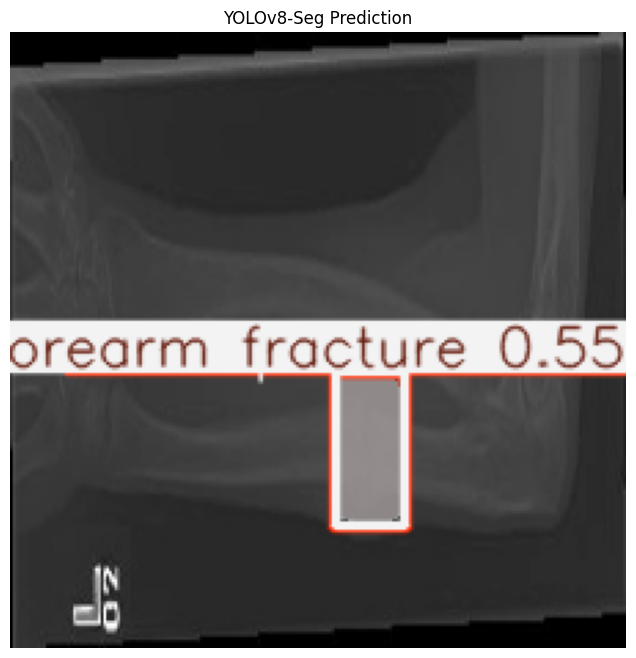

In [119]:
# before resuming
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# load trained model
model = YOLO("C:/Users/Home/Desktop/jupyter_python/runs/segment/bone_fracture_v1502/weights/best.pt")  # مثال: "runs/segment/train/weights/best.pt"
image_folder = test_images_path
# load the image
img_name = random.choice(os.listdir(image_folder)) 
img_path = os.path.join(image_folder, img_name)


img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# prediction
prediction1 = model.predict(source=img_path, save=False, conf=0.1)
#print(prediction1)
# plotting the prediction
for r in prediction1:
    
    im_show = r.plot(labels=True, boxes=True)

plt.figure(figsize=(8, 8))
plt.imshow(im_show, cmap = 'gray')
plt.axis('off')
plt.title("YOLOv8-Seg Prediction")
plt.show()


image 1/1 C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\test\images\image1_2336_png.rf.76087ca1e6263ce05700b7e1f92b9f02.jpg: 224x224 2 shoulder fractures, 50.7ms
Speed: 0.6ms preprocess, 50.7ms inference, 4.3ms postprocess per image at shape (1, 3, 224, 224)


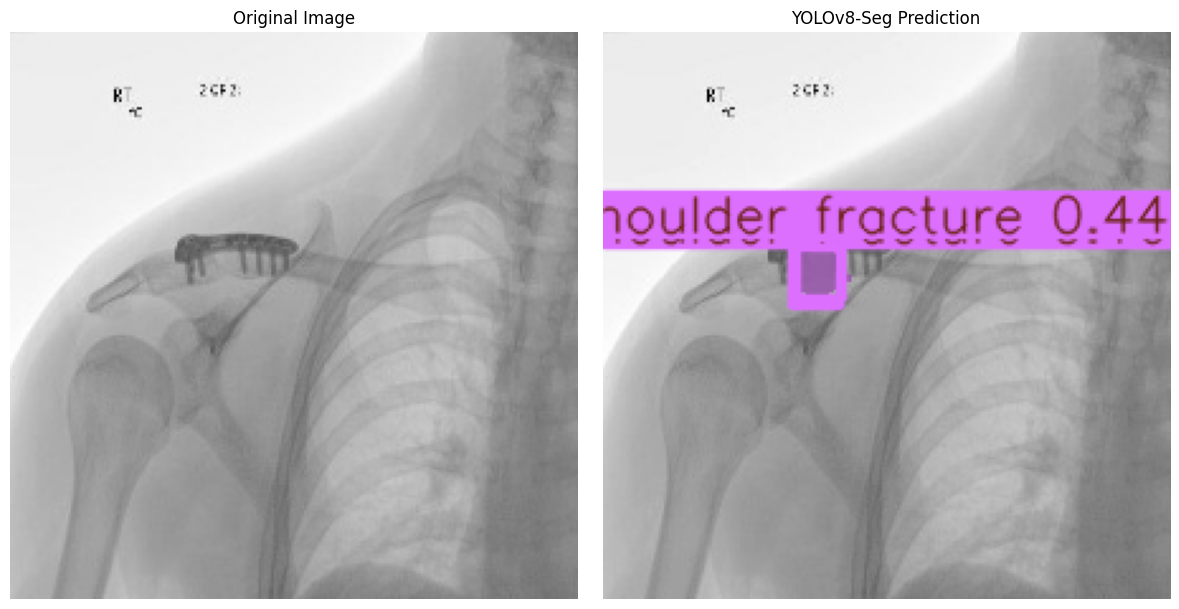

In [36]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
import random

# load trained model
model = YOLO("C:/Users/Home/Desktop/jupyter_python/runs/segment/bone_fracture_v1502/weights/best.pt")

image_folder = test_images_path

# choose a random image
img_name = random.choice([f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))])
img_path = os.path.join(image_folder, img_name)

# original image
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# model's prediction
prediction1 = model.predict(source=img_path, save=False, conf=0.1)

# plot results
for r in prediction1:
    im_show = r.plot(labels=True, boxes=True)  

# show the images
plt.figure(figsize=(12, 6))

# original image
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis('off')

# prediction
plt.subplot(1, 2, 2)
plt.imshow(im_show)
plt.title("YOLOv8-Seg Prediction")
plt.axis('off')

plt.tight_layout()
plt.show()


Results plot

In [ ]:
# Results image path
results_path = "C:/Users/Home/Desktop/jupyter_python/runs/segment/bone_fracture_v1502/results.png"

# load the image
img = cv2.imread(results_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# show the image
plt.figure(figsize=(12, 6))
plt.imshow(img_rgb)
plt.title("Training/Validation Results")
plt.axis('off')
plt.show()


# TRIES

In [5]:
from ultralytics import YOLO

yaml_path = r"C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\data.yaml"
model = YOLO(r"runs/segment/bone_fracture_v70/weights/last.pt")
results = model.train(
    data=yaml_path,
    epochs=100,
    imgsz=224,
    batch=16,
    patience=20,
    device='cuda',
    optimizer='AdamW',                                ###################old
    lr0=0.001,
    cos_lr=True,
    weight_decay=0.0005,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=10.0,
    fliplr=0.5,
    flipud=0.0,
    mosaic=1.0,
    task='segment',
    name='bone_fracture_v71'
)

New https://pypi.org/project/ultralytics/8.3.122 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.116  Python-3.12.7 torch-2.7.0+cu128 CUDA:0 (Quadro M1000M, 2048MiB)
engine\trainer: task=segment, mode=train, model=runs/segment/bone_fracture_v70/weights/last.pt, data=C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\data.yaml, epochs=100, time=None, patience=20, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=bone_fracture_v714, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, 

train: Scanning C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\train\labels... 5033 images, 1


train: New cache created: C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.10.0 ms, read: 45.714.8 MB/s, size: 8.4 KB)


val: Scanning C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\valid\labels... 348 images, 175 


val: New cache created: C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\valid\labels.cache
Plotting labels to runs\segment\bone_fracture_v714\labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs\segment\bone_fracture_v714
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.29G          2      2.938       1.85      1.383          6        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.257      0.231      0.183     0.0638       0.24      0.221      0.176     0.0591



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001F19CAC44A0>
Traceback (most recent call last):
  File "C:\miniconda\condainstall\Lib\site-packages\torch\utils\data\dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "C:\miniconda\condainstall\Lib\site-packages\torch\utils\data\dataloader.py", line 1621, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.14G      1.992      2.916      1.705      1.362         10        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.198      0.232       0.18     0.0603      0.234      0.225      0.188     0.0593



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.16G      2.011      2.923      1.734      1.375         13        224: 100%|██████████| 315/315 [06:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.223      0.172      0.134      0.044      0.197      0.157      0.115     0.0399



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.13G      2.034      2.902      1.759      1.379          9        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.223      0.245      0.186     0.0648      0.181       0.22      0.168     0.0574



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.14G      2.026      2.898      1.711      1.371          6        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.262      0.212       0.18     0.0556      0.253      0.198      0.167     0.0502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.06G      2.013      2.884      1.725      1.375         11        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.217      0.173      0.161     0.0512      0.217      0.172      0.158     0.0535



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.14G      1.996      2.895      1.702      1.364         14        224: 100%|██████████| 315/315 [07:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.218      0.247       0.18     0.0605      0.207      0.223      0.169     0.0582



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.14G      1.983      2.873      1.668      1.352          8        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.203       0.22      0.151     0.0452      0.215      0.217      0.155      0.043



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.16G      1.935      2.818      1.601      1.327         14        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.266      0.222      0.189      0.063      0.238      0.221      0.177     0.0615



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.05G      1.953      2.815      1.631      1.345         12        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.235      0.262      0.211     0.0579      0.221      0.207      0.175      0.051



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.16G       1.94      2.821      1.587      1.329         10        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.359      0.217      0.186     0.0574      0.265      0.216      0.176     0.0601



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.13G      1.894       2.75      1.537      1.318         10        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204       0.23      0.242      0.174     0.0521      0.198      0.199      0.138     0.0456



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.14G      1.901      2.749      1.547      1.314         12        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.237      0.245      0.182     0.0682      0.214      0.254       0.17     0.0624



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.05G      1.909      2.765      1.506      1.321         10        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.233      0.255      0.179     0.0551      0.279      0.202      0.184     0.0603



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.15G       1.88      2.727      1.512      1.305         11        224: 100%|██████████| 315/315 [08:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.254      0.169      0.149     0.0485      0.299      0.159       0.15     0.0464



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.13G      1.881      2.717      1.503      1.299          7        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204       0.32      0.222      0.189     0.0591      0.324      0.194      0.175     0.0562



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.16G      1.835      2.708      1.437      1.283         12        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.305       0.23      0.204     0.0685      0.292      0.208      0.187     0.0595



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.06G      1.832      2.644      1.414      1.278         14        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.321      0.223      0.177     0.0589      0.362      0.238      0.196     0.0548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.16G      1.799      2.594      1.392      1.264          9        224: 100%|██████████| 315/315 [11:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.283      0.217       0.19     0.0629      0.286      0.179      0.174     0.0561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.15G      1.757      2.533      1.329      1.256         12        224: 100%|██████████| 315/315 [06:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204       0.26      0.266      0.212     0.0708      0.276      0.259      0.205     0.0669



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.16G      1.778      2.585      1.355      1.255          7        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.283      0.252      0.213     0.0729      0.237      0.224      0.173     0.0581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.06G       1.77      2.545      1.344      1.258         12        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.309      0.202      0.186       0.07       0.33      0.212      0.193     0.0742



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.14G      1.718      2.487      1.287      1.228         10        224: 100%|██████████| 315/315 [09:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.331      0.226      0.204     0.0668      0.325      0.218      0.187      0.058



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.16G      1.696       2.46      1.278      1.224          9        224: 100%|██████████| 315/315 [06:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.346      0.207      0.205      0.077      0.248      0.237      0.181     0.0667



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.14G      1.706        2.5      1.271      1.227          6        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.306      0.228      0.198     0.0661      0.296      0.217      0.185     0.0696



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.04G      1.692      2.476      1.263      1.217         11        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.371       0.23      0.239     0.0795       0.32      0.196       0.19     0.0669



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.14G      1.684      2.471      1.232      1.212         13        224: 100%|██████████| 315/315 [06:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.339      0.223      0.214     0.0709      0.343      0.219      0.211     0.0648



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.12G      1.657      2.399      1.204        1.2         17        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.313      0.229       0.23     0.0823      0.299      0.254      0.218     0.0678



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.15G      1.662      2.417       1.22      1.209         11        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.311      0.322      0.236      0.069      0.276      0.265      0.209     0.0645



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.05G      1.632       2.36      1.179      1.197         10        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.338      0.234      0.216     0.0758      0.352      0.226      0.211     0.0673



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.16G      1.637       2.38      1.172      1.197         12        224: 100%|██████████| 315/315 [06:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.375       0.23      0.238     0.0743      0.365      0.211      0.214     0.0657



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.14G       1.65      2.368      1.177      1.201          7        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.375      0.224      0.202     0.0616      0.381       0.22      0.182     0.0573



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.16G      1.601      2.344      1.147      1.177          6        224: 100%|██████████| 315/315 [07:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.368      0.223      0.218     0.0627      0.357      0.212      0.204      0.056



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.06G      1.588      2.324      1.121      1.157         12        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.288      0.243      0.212     0.0664      0.237      0.247      0.189     0.0605



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.15G      1.592      2.321      1.102      1.174         14        224: 100%|██████████| 315/315 [07:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.307      0.272      0.207     0.0638      0.291      0.252      0.182     0.0571



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.17G      1.603      2.294      1.124      1.177          8        224: 100%|██████████| 315/315 [09:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204       0.31      0.242      0.192     0.0672      0.336      0.256      0.201     0.0642



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.15G      1.557      2.267      1.096      1.155         13        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.339      0.258      0.244     0.0774       0.27      0.245      0.206     0.0631



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.04G      1.541      2.261      1.074      1.149         10        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.324      0.239      0.235     0.0763      0.309        0.2      0.205     0.0685



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.16G      1.524      2.233      1.072      1.139          7        224: 100%|██████████| 315/315 [07:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.272      0.219      0.205     0.0642      0.224      0.202      0.179     0.0545



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.14G      1.494      2.168      1.029      1.136          9        224: 100%|██████████| 315/315 [08:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.393       0.23      0.233     0.0729      0.369      0.219      0.223     0.0709



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.16G      1.511      2.195      1.044      1.134         11        224: 100%|██████████| 315/315 [6:1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.261      0.237      0.202     0.0672      0.253      0.239      0.191     0.0608



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.05G      1.493      2.176      1.031      1.129         15        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.409      0.186      0.202     0.0693      0.383      0.177       0.19      0.063



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.17G      1.497      2.178      1.037       1.13          7        224: 100%|██████████| 315/315 [06:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.306      0.199      0.198     0.0667      0.282      0.199      0.182     0.0545



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.14G      1.454      2.129       0.98      1.116         14        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.374      0.235      0.238     0.0823       0.28      0.263      0.219     0.0743



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.14G      1.454      2.116     0.9915      1.111         10        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.334       0.27      0.226     0.0749      0.312      0.256       0.21     0.0669



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.06G      1.458      2.134     0.9932      1.119         10        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.413      0.217      0.234     0.0719      0.338      0.179      0.187     0.0564



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.14G      1.431      2.081     0.9696      1.105          3        224: 100%|██████████| 315/315 [08:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.323      0.236      0.213     0.0697      0.307      0.229      0.187     0.0574



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.14G      1.411       2.09     0.9317      1.097         10        224: 100%|██████████| 315/315 [08:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.434        0.2      0.219     0.0762      0.295      0.243      0.216     0.0648



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.14G      1.417      2.076     0.9487      1.098          7        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.314      0.261      0.232     0.0726      0.306      0.245      0.216     0.0639



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.06G      1.411      2.077     0.9462      1.103         12        224: 100%|██████████| 315/315 [1:2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.404      0.248      0.244     0.0759      0.336      0.224      0.231     0.0685



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.16G      1.399      2.043     0.9298      1.099         12        224: 100%|██████████| 315/315 [08:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.351      0.238      0.233     0.0783      0.329      0.207      0.215     0.0653



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.15G      1.398      2.018     0.9265       1.09         12        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.356      0.261      0.224     0.0834      0.347      0.252      0.222     0.0707



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.15G      1.354      2.015     0.9035      1.072          9        224: 100%|██████████| 315/315 [06:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.363      0.217      0.228     0.0772      0.285      0.234      0.212     0.0628



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.04G      1.345      1.981     0.8831      1.076         11        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.375      0.223      0.225     0.0814       0.36       0.22      0.224     0.0634



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.16G      1.366      1.995     0.9014      1.073          8        224: 100%|██████████| 315/315 [07:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.372      0.244      0.232     0.0771      0.376      0.243      0.218     0.0637



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.14G      1.322       1.91     0.8493      1.057          8        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.376      0.278      0.252     0.0826      0.325      0.264      0.233     0.0712



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.15G      1.312      1.916     0.8638      1.055          9        224: 100%|██████████| 315/315 [06:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.379      0.249      0.246     0.0835      0.323      0.214      0.218     0.0679



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.05G      1.343      1.937     0.8763       1.07         12        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.439      0.245      0.258     0.0867      0.398      0.229      0.247     0.0773



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.16G      1.312      1.912     0.8546      1.064         14        224: 100%|██████████| 315/315 [11:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.385      0.247      0.239     0.0766      0.365      0.226      0.209     0.0619



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.15G      1.293      1.872     0.8427      1.048         10        224: 100%|██████████| 315/315 [06:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.368      0.232      0.233     0.0819      0.327      0.238      0.228     0.0624



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.14G      1.292      1.906     0.8502      1.052         13        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.309      0.263      0.233     0.0856      0.298      0.243      0.222     0.0706



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.04G      1.267      1.849     0.8047      1.045         10        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.323      0.242      0.231      0.082      0.302      0.233       0.22     0.0695



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.16G       1.25       1.83     0.7976      1.036         13        224: 100%|██████████| 315/315 [08:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.338      0.249      0.226     0.0861      0.314      0.236       0.21     0.0698



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.14G      1.252      1.848     0.8024      1.036         10        224: 100%|██████████| 315/315 [06:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.316      0.251      0.226     0.0793      0.296      0.223      0.203     0.0652



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.15G      1.264      1.856      0.819      1.036         15        224: 100%|██████████| 315/315 [06:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.328      0.229      0.233     0.0856      0.306      0.224      0.234     0.0732



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.04G      1.246      1.813     0.7889      1.034          7        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204       0.28      0.237      0.223     0.0804      0.267       0.23      0.217     0.0705



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.14G      1.238      1.784     0.7788      1.033          6        224: 100%|██████████| 315/315 [07:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.276      0.221      0.219     0.0847      0.285      0.231      0.232     0.0718



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.12G      1.233      1.788     0.7869      1.027          4        224: 100%|██████████| 315/315 [08:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.332      0.272      0.236     0.0873      0.318      0.262      0.233     0.0761



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.15G      1.239      1.833     0.7963      1.024          9        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.324      0.267      0.239     0.0852      0.291      0.258       0.22     0.0785



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.05G      1.206      1.763     0.7725      1.024          5        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.339      0.234      0.232     0.0783      0.311      0.212      0.212     0.0682



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.93G       1.19      1.731     0.7408      1.016         21        224:  35%|███▍      | 110/315 [03:


KeyboardInterrupt: 

In [1]:
from ultralytics import YOLO

yaml_path = r"C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\data.yaml"
model = YOLO(r"runs/segment/bone_fracture_v14/weights/last.pt")
results = model.train(
    data=yaml_path,
    epochs=100,
    imgsz=224,
    batch=16,
    patience=30,
    device='cuda',                         #################old
    optimizer='AdamW',
    lr0=0.0005,
    weight_decay=0.0005,
    hsv_h=0.015,
    hsv_s=0.4,
    hsv_v=0.2,
    fliplr=0.5,
    flipud=0.0,
    mosaic=0.5,
    task='segment',
    name='bone_fracture_v70'
)

New https://pypi.org/project/ultralytics/8.3.122 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.116  Python-3.12.7 torch-2.7.0+cu128 CUDA:0 (Quadro M1000M, 2048MiB)
engine\trainer: task=segment, mode=train, model=runs/segment/bone_fracture_v14/weights/last.pt, data=C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\data.yaml, epochs=100, time=None, patience=30, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=bone_fracture_v70, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, 

train: Scanning C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\train\labels.cache... 5033 ima

train: C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\train\images\image1_1002_png.rf.1feafce607366113c97124dc22d52328.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
train: C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\train\images\image1_1002_png.rf.1feafce607366113c97124dc22d52328_aug0.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
train: C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\train\images\image1_1002_png.rf.1feafce607366113c97124dc22d52328_aug1.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
train: C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\train\images\image1_1002_png.rf.67c46c90c7089ef2ffa40b5fa22e4ad1.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. 

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.10.0 ms, read: 44.48.4 MB/s, size: 8.4 KB)


val: Scanning C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\valid\labels.cache... 348 images

val: C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\valid\images\image1_1090_png.rf.de645f822a5e36175c5e988223f4eeb0.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
val: C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\valid\images\image1_111_png.rf.3893d8f7588cea4d796d26119e52637f.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
val: C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\valid\images\image1_119_png.rf.77de12cb566fc295603927e2a5b2748a.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
val: C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\valid\images\image1_1310_png.rf.daf759fe071a5733142e9847fb388e75.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class label

Plotting labels to runs\segment\bone_fracture_v70\labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs\segment\bone_fracture_v70
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.57G       2.36      3.426      2.324      1.604          2        224: 100%|██████████| 292/292 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.195      0.173       0.15     0.0582      0.171      0.173      0.149     0.0522



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.74G      2.277      3.242      2.151      1.561          5        224: 100%|██████████| 292/292 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.251      0.226      0.185     0.0541      0.229      0.215      0.169     0.0493



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.84G      2.244        3.2      2.071       1.53          3        224: 100%|██████████| 292/292 [06:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176       0.29       0.22      0.209     0.0732      0.284        0.2      0.199     0.0725



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.84G      2.171      3.115      1.975      1.501          3        224: 100%|██████████| 292/292 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.284      0.222       0.22     0.0742      0.215      0.253      0.207     0.0725



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.83G      2.119      3.051      1.878      1.496          2        224: 100%|██████████| 292/292 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.322      0.235      0.225     0.0724      0.348      0.233       0.21     0.0686



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.81G      2.123      3.063       1.86      1.482          4        224: 100%|██████████| 292/292 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.299      0.197      0.177     0.0532       0.22      0.187      0.184     0.0573



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.77G      2.085      2.943      1.781      1.456          2        224: 100%|██████████| 292/292 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.335      0.214      0.229     0.0729      0.315      0.238      0.218     0.0667



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.76G      2.053      2.964      1.715      1.445          4        224: 100%|██████████| 292/292 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176       0.28      0.244      0.211     0.0725       0.26      0.223      0.187     0.0576



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.91G      2.023       2.93      1.704      1.438          2        224: 100%|██████████| 292/292 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.358      0.228      0.225     0.0699       0.25      0.226      0.198     0.0618



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.91G      1.968      2.867      1.597      1.403          4        224: 100%|██████████| 292/292 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.486      0.232      0.248     0.0848      0.338      0.233      0.233       0.08



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.92G      1.948      2.813      1.577      1.391          5        224: 100%|██████████| 292/292 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.409      0.291      0.263     0.0827      0.366      0.276      0.252     0.0712



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.92G      1.942      2.828      1.579      1.383          4        224: 100%|██████████| 292/292 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.337       0.25      0.231     0.0707      0.354      0.266      0.239     0.0735



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.91G      1.886      2.756      1.504      1.341          3        224: 100%|██████████| 292/292 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.344      0.266      0.258     0.0877      0.378      0.247      0.249     0.0843



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.85G      1.858      2.687      1.446      1.347          6        224: 100%|██████████| 292/292 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.347      0.267      0.274      0.091      0.296      0.315      0.262     0.0803



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.83G      1.824       2.67      1.404      1.323          6        224: 100%|██████████| 292/292 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.302      0.256      0.235     0.0815      0.346      0.212      0.222     0.0699



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.79G      1.791      2.592      1.334      1.311          5        224: 100%|██████████| 292/292 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.423      0.269      0.263     0.0925      0.391      0.273      0.237     0.0767



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.91G      1.774      2.605      1.342      1.309          3        224: 100%|██████████| 292/292 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176       0.32      0.275       0.23     0.0713      0.293      0.249      0.212     0.0696



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.91G      1.747      2.582        1.3      1.294          2        224: 100%|██████████| 292/292 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.315      0.256      0.209      0.067      0.309      0.259      0.208     0.0647



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.92G      1.763      2.596      1.333      1.296          1        224: 100%|██████████| 292/292 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.355      0.288      0.239     0.0813      0.332      0.275      0.227     0.0743



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.75G      1.723      2.541      1.272      1.273          7        224: 100%|██████████| 292/292 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.343      0.296      0.254     0.0822      0.307      0.263      0.232     0.0807



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.85G       1.68      2.473      1.238      1.265          2        224: 100%|██████████| 292/292 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176       0.32      0.293      0.228     0.0758      0.337      0.273      0.219     0.0669



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.84G      1.681      2.483        1.2      1.259          2        224: 100%|██████████| 292/292 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.339      0.283      0.254     0.0804       0.32      0.257      0.234     0.0706



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.84G      1.638      2.443      1.171      1.239          4        224: 100%|██████████| 292/292 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.397      0.289      0.269        0.1      0.384      0.268      0.254     0.0959



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.84G      1.632      2.422      1.155      1.243          3        224: 100%|██████████| 292/292 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.363      0.254      0.255     0.0883      0.361      0.263      0.255     0.0875



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.79G      1.636      2.411      1.142      1.245          5        224: 100%|██████████| 292/292 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.358      0.246      0.243     0.0811      0.341      0.241      0.234     0.0811



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.79G      1.579       2.33      1.093      1.214          2        224: 100%|██████████| 292/292 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.276      0.253      0.224     0.0678       0.27      0.247      0.209     0.0693



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.79G       1.57      2.356      1.089        1.2          4        224: 100%|██████████| 292/292 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.352      0.287      0.237     0.0817      0.338      0.281      0.219     0.0752



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.79G      1.541      2.326      1.083      1.205          4        224: 100%|██████████| 292/292 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        331        176      0.408      0.231      0.256     0.0838      0.356      0.211       0.23     0.0804



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.91G      1.548       2.31      1.075      1.193          6        224: 100%|██████████| 292/292 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


KeyboardInterrupt: 


image 1/1 C:\Users\Home\Desktop\m.png: 224x224 2 forearm fractures, 51.2ms
Speed: 0.8ms preprocess, 51.2ms inference, 4.7ms postprocess per image at shape (1, 3, 224, 224)


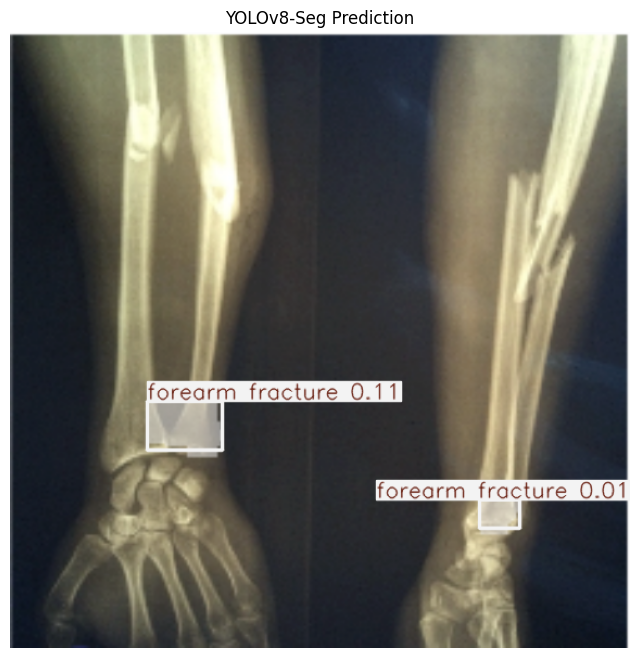

In [23]:
# after resuming
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# تحميل النموذج المدرب
model = YOLO("C:/Users/Home/Desktop/jupyter_python/runs/segment/bone_fracture_v714/weights/best.pt")  # مثال: "runs/segment/train/weights/best.pt"
#image_folder = test_images_path
# load the image
img_path = "C:/Users/Home/Desktop/m.png"            #random.choice(os.listdir(image_folder)) # "C:/Users/Home/Desktop/ahmed.jpg"
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# prediction
prediction1 = model.predict(source=img_path, save=False, conf=0.01)
#print(prediction1)
# plotting the prediction
for r in prediction1:
    
    im_show = r.plot(labels=True, boxes=True)

plt.figure(figsize=(8, 8))
plt.imshow(im_show, cmap = 'gray')
plt.axis('off')
plt.title("YOLOv8-Seg Prediction")
plt.show()

In [6]:
model = YOLO('yolov8l-seg.pt')
results = model.train(
    data=yaml_path,
    epochs=100,
    imgsz=224,
    batch=16,  
    patience=30,
    device='cuda',
    optimizer='AdamW',
    lr0=0.001,
    cos_lr=True,
    weight_decay=0.001,
    hsv_h=0.02,
    hsv_s=0.8,
    hsv_v=0.5,
    degrees=15.0,                  ########################3 old
    fliplr=0.5,
    flipud=0.5,
    mosaic=0.6,
    workers=0,
    task='segment',
    name='bone_fracture_v90'
)

100%|██████████████████████████████████████████████████████████████████████████████| 88.1M/88.1M [01:33<00:00, 993kB/s]


New https://pypi.org/project/ultralytics/8.3.123 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.116  Python-3.12.7 torch-2.7.0+cu128 CUDA:0 (Quadro M1000M, 2048MiB)
engine\trainer: task=segment, mode=train, model=yolov8l-seg.pt, data=C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\data.yaml, epochs=100, time=None, patience=30, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=cuda, workers=0, project=None, name=bone_fracture_v90, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None,

train: Scanning C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\train\labels... 5033 images, 1


train: New cache created: C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.10.0 ms, read: 18.47.1 MB/s, size: 8.4 KB)


val: Scanning C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\valid\labels... 348 images, 175 

val: New cache created: C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\valid\labels.cache


Plotting labels to runs\segment\bone_fracture_v90\labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 106 weight(decay=0.0), 117 weight(decay=0.001), 116 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs\segment\bone_fracture_v90
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.15G      3.339       4.46      4.284       2.09          7        224: 100%|██████████| 315/315 [35:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.511     0.0398      0.004     0.0011      0.515     0.0216    0.00372   0.000817



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001F19CAC44A0>
Traceback (most recent call last):
  File "C:\miniconda\condainstall\Lib\site-packages\torch\utils\data\dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "C:\miniconda\condainstall\Lib\site-packages\torch\utils\data\dataloader.py", line 1621, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.78G      3.164      4.302      4.022       1.95         15        224:  34%|███▍      | 108/315 [12:


KeyboardInterrupt: 

In [15]:
from ultralytics import YOLO

model = YOLO('yolov8l-seg.pt')
results2 = model.train(
    data=yaml_path,
    epochs=100,
    imgsz=224,
    batch=8,  
    patience=10,
    device='cuda',
    optimizer='AdamW',
    lr0=0.0005,  
    cos_lr=True,
    weight_decay=0.001,
    hsv_h=0.015,   
    workers=0,
    task='segment',
    name='bone_fracture_v601'
)

New https://pypi.org/project/ultralytics/8.3.123 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.116  Python-3.12.7 torch-2.7.0+cu128 CUDA:0 (Quadro M1000M, 2048MiB)
engine\trainer: task=segment, mode=train, model=yolov8l-seg.pt, data=final_bones/BoneFractureYolo8_final/data.yaml, epochs=100, time=None, patience=10, batch=8, imgsz=224, save=True, save_period=-1, cache=False, device=cuda, workers=0, project=None, name=bone_fracture_v601, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show

train: Scanning C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\train\labels... 5033 images, 1


train: New cache created: C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.10.0 ms, read: 67.624.7 MB/s, size: 8.4 KB)


val: Scanning C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\valid\labels... 348 images, 175 

val: New cache created: C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\valid\labels.cache


Plotting labels to runs\segment\bone_fracture_v601\labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 106 weight(decay=0.0), 117 weight(decay=0.001), 116 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs\segment\bone_fracture_v601
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100       5.3G      3.219      4.207      4.083      1.938          3        224: 100%|██████████| 630/630 [59:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.524     0.0263    0.00604    0.00225      0.522     0.0178    0.00413    0.00143



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100       3.9G      3.069       4.06      3.734      1.822          1        224: 100%|██████████| 630/630 [52:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.568     0.0516     0.0676     0.0185      0.558     0.0501     0.0595     0.0132



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.89G      2.923      3.856      3.509      1.751          0        224: 100%|██████████| 630/630 [46:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.369     0.0617     0.0425    0.00961      0.536     0.0617     0.0372     0.0101



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.89G      2.857      3.799      3.333      1.712          0        224: 100%|██████████| 630/630 [42:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.282      0.105     0.0688     0.0183      0.229     0.0975     0.0592     0.0136



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.89G      2.763      3.722      3.129      1.676          1        224: 100%|██████████| 630/630 [47:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.281      0.115     0.0796     0.0264      0.269      0.111     0.0725     0.0238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.89G      2.715      3.619      3.047      1.681         15        224:  94%|█████████▍| 592/630 [5:1


KeyboardInterrupt: 

In [4]:
from ultralytics import YOLO

model = YOLO('yolov8m-seg.pt')

# Train with Roboflow dataset     ################ old
results = model.train(
    data= yaml_path,
    epochs=100,
    imgsz=224,
    batch=16,
    patience=30,  # Stop if no improvement for 30 epochs
    device='cuda',   # Use GPU
    optimizer='AdamW',
    lr0=0.001, # Initial learning rate
    task='segment',
    weight_decay=0.0005,
    hsv_h=0.015,# Hue augmentation
    hsv_s=0.4,     # saturation
    hsv_v=0.2,     #  value
    fliplr=0.5,    #  HorizontalFlip 
    flipud=0.0,    # no vertical flip
    mosaic=0.0,    # stop mosaic 
    
    name='bone_fracture_v80'
)

New https://pypi.org/project/ultralytics/8.3.122 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.116  Python-3.12.7 torch-2.7.0+cu128 CUDA:0 (Quadro M1000M, 2048MiB)
engine\trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=final_bones/BoneFractureYolo8_final/data.yaml, epochs=100, time=None, patience=30, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=bone_fracture_v80, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sho

train: Scanning C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\train\labels.cache... 5033 ima

train: C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\train\images\image1_1002_png.rf.1feafce607366113c97124dc22d52328.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
train: C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\train\images\image1_1002_png.rf.1feafce607366113c97124dc22d52328_aug0.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
train: C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\train\images\image1_1002_png.rf.1feafce607366113c97124dc22d52328_aug1.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. Possible class labels are 0-5
train: C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\train\images\image1_1002_png.rf.67c46c90c7089ef2ffa40b5fa22e4ad1.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 6. 

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


KeyboardInterrupt: 

# RESUME THE NEW MODEL

In [1]:
from ultralytics import YOLO

yaml_path = r"C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\data.yaml"
model = YOLO("C:/Users/Home/Desktop/jupyter_python/runs/segment/bone_fracture_v1502/weights/best.pt")
results3 = model.train(
    data=yaml_path,
    epochs=100,
    imgsz=224,
    batch=16,  
    patience=20,
    device='cuda',
    optimizer='AdamW',
    lr0=0.001,
    cos_lr=True,
    weight_decay=0.001,                
    hsv_h=0.02,
    hsv_s=0.8,
    hsv_v=0.5,
    degrees=5.0,
    mosaic=0.6,
    task='segment', 
    name='bone_fracture_v13072003'
)

New https://pypi.org/project/ultralytics/8.3.126 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.116  Python-3.12.7 torch-2.7.0+cu128 CUDA:0 (Quadro M1000M, 2048MiB)
engine\trainer: task=segment, mode=train, model=C:/Users/Home/Desktop/jupyter_python/runs/segment/bone_fracture_v1502/weights/best.pt, data=C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\data.yaml, epochs=100, time=None, patience=20, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=bone_fracture_v13072003, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_bu

train: Scanning C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\train\labels.cache... 5033 ima


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.20.0 ms, read: 16.74.3 MB/s, size: 8.4 KB)


val: Scanning C:\Users\Home\Desktop\jupyter_python\final_bones\BoneFractureYolo8_final\valid\labels.cache... 348 images


Plotting labels to runs\segment\bone_fracture_v13072003\labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.001), 96 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs\segment\bone_fracture_v13072003
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.76G      1.815      2.676      1.432      1.314          9        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.237      0.195      0.152      0.043      0.229       0.19      0.149     0.0387



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.04G      1.785      2.634      1.416      1.284         11        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204       0.38      0.187      0.204     0.0652      0.392      0.171      0.198     0.0593



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.04G      1.766      2.571      1.376      1.284          5        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.226      0.308      0.219     0.0712      0.228      0.286      0.206     0.0624



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.01G      1.754      2.574      1.384      1.276          9        224: 100%|██████████| 315/315 [09:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.352      0.211      0.182     0.0566      0.307      0.172      0.162     0.0481



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.04G      1.757      2.567      1.411      1.272         12        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.319      0.277      0.224     0.0768      0.287       0.26      0.202      0.066



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.95G      1.761      2.577      1.386      1.269          7        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.344      0.239      0.213     0.0673      0.285      0.204      0.191     0.0619



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.04G      1.727      2.515      1.322      1.253         10        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.299      0.289      0.235     0.0764      0.346      0.229      0.225     0.0715



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.05G      1.714      2.496      1.308      1.253          7        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.402      0.226      0.225     0.0749      0.346      0.217      0.218     0.0599



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.03G       1.72       2.53      1.289      1.259         10        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.273      0.213      0.194     0.0699      0.299      0.205      0.191     0.0649



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.94G      1.701      2.486      1.315      1.258         10        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.296      0.309      0.216     0.0725       0.28      0.287       0.19     0.0606



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.03G      1.689      2.497      1.259      1.245         10        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.335        0.2      0.207     0.0746      0.329       0.19      0.187     0.0607



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100       2.1G      1.696      2.471      1.282      1.243          7        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.263      0.237      0.205     0.0754      0.246      0.221       0.18     0.0579



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.03G      1.674      2.477      1.259      1.239          3        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.254      0.221      0.178     0.0574      0.231      0.186      0.158     0.0506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.95G      1.671      2.404      1.255      1.233          9        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204       0.24      0.275      0.196      0.064      0.214      0.257      0.178     0.0547



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.03G      1.664      2.434      1.235      1.228         10        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.294      0.241      0.196     0.0705      0.301      0.197      0.182     0.0623



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.03G      1.639      2.405      1.209      1.223          8        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.266      0.256       0.21     0.0676      0.294      0.228      0.194     0.0572



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.04G      1.652      2.365      1.211       1.22          9        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.313      0.219      0.214     0.0686      0.256      0.226      0.188     0.0604



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.94G      1.612      2.378      1.147        1.2          8        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.291      0.269      0.206     0.0747       0.26      0.233      0.183     0.0633



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.04G      1.595      2.303      1.143       1.19          6        224: 100%|██████████| 315/315 [06:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.378      0.223      0.211     0.0709      0.334      0.192      0.185     0.0624



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.03G      1.553      2.257      1.092      1.181          5        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.311      0.232      0.206     0.0655      0.281      0.206      0.186     0.0583



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.03G      1.584      2.292      1.128       1.19         12        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.289      0.252      0.211     0.0715      0.272      0.241      0.191     0.0617



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.95G      1.559      2.293      1.108      1.169          9        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.329      0.235      0.219     0.0729      0.295      0.201       0.19     0.0603



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.04G      1.545      2.317      1.117      1.186         10        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.285      0.233      0.202     0.0735      0.263      0.254      0.197     0.0617



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.02G      1.515      2.219       1.05      1.165         10        224: 100%|██████████| 315/315 [09:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.224      0.245      0.181     0.0621      0.202      0.226      0.176     0.0509



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.03G      1.532      2.263      1.074      1.157          6        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204       0.27      0.278      0.199     0.0723      0.255      0.256      0.193     0.0617



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.94G      1.533      2.257      1.065      1.171         13        224: 100%|██████████| 315/315 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.439      0.228       0.24     0.0771      0.352      0.197      0.212     0.0618



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.05G      1.536      2.241      1.057      1.163          7        224: 100%|██████████| 315/315 [10:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        348        204      0.305      0.264      0.232     0.0775       0.27      0.207      0.189     0.0616
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 7, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



27 epochs completed in 2.800 hours.
Optimizer stripped from runs\segment\bone_fracture_v13072003\weights\last.pt, 54.8MB
Optimizer stripped from runs\segment\bone_fracture_v13072003\weights\best.pt, 54.8MB

Validating runs\segment\bone_fracture_v13072003\weights\best.pt...
Ultralytics 8.3.116  Python-3.12.7 torch-2.7.0+cu128 CUDA:0 (Quadro M1000M, 2048MiB)
YOLOv8m-seg summary (fused): 105 layers, 27,225,858 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        348        204      0.298      0.289      0.234     0.0761      0.346      0.229      0.225     0.0714
        elbow positive         28         29     0.0685      0.103     0.0557     0.0133     0.0933      0.069     0.0484     0.0109
      fingers positive         41         48      0.199      0.271      0.109     0.0241      0.124     0.0833     0.0766     0.0185
      forearm fracture         37         43      0.371      0.326      0.314      0.118      0.587      0.372       0.36      0.125
        wrist positive         17         28      0.133      0.107     0.0539     0.0287      0.207     0.0714     0.0438     0.0205
               humerus         31         36      0.598      0.528      0.569       0.17      0.703      0.528      0.552      0.166
     shoulder fracture         19         20       0.42        0.4      0.304      0.102      0.362       0.25      0.267     0.0874
Speed: 0.1ms preprocess, 22.8ms inference, 0.0ms loss, 1.5ms postproc